# Assignement 2 H2O AutoML

**The Bank Customer Churn dataset contains the following features:**

1.CustomerID

2.Credit Score

3.Country

4.Gender

5.Age

6.Tenure

7.Balance

8.Product Number

9.Credit Card

10.Active Member

11.Estimated Salary

12.Churn

# Importing packages and dataset

In [ ]:
#importing packages
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
from scipy import stats # entropy calculation
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf #OLS model Library

import h2o
from h2o.automl import H2OAutoML
import psutil

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [ ]:
min_mem_size=6
run_time=222

In [ ]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [ ]:
port_no=random.randint(5555,55555)

try:
    h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
    logging.critical('h2o.init')
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:35057..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpddz8ydi6
  JVM stdout: /tmp/tmpddz8ydi6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpddz8ydi6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:35057
Connecting to H2O server at http://127.0.0.1:35057 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         07 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    1 month and 29 days
H2O_cluster_name:           H2O_from_python_unknownUser_17szuk
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:35057
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/anshvaghela2099/INFO-6105/main/Bank_Customer_Churn_Prediction.csv")

In [ ]:
#removing column customerid as it will not have an impact on our analysis
df.drop(columns=['customer_id'], inplace=True)

In [ ]:
from scipy import stats

# Generating Data Summary

Entroy is used to understand the distribution of data in the features

In [ ]:
def summarytable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['Sample Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2)
    return summary

summarytable(df)

Dataset Shape: (10000, 11)


Name   dtypes  Missing  Uniques Sample Value  Entropy
0       credit_score    int64        0      460          619     2.55
1            country   object        0        3       France     0.45
2             gender   object        0        2       Female     0.30
3                age    int64        0       70           42     1.60
4             tenure    int64        0       11            2     1.03
5            balance  float64        0     6382          0.0     2.71
6    products_number    int64        0        4            1     0.36
7        credit_card    int64        0        2            1     0.26
8      active_member    int64        0        2            1     0.30
9   estimated_salary  float64        0     9999    101348.88     4.00
10             churn    int64        0        2            1     0.22

# Numerical and Categorical Columns

In [ ]:
#numeric columns
num_cols = df.select_dtypes('number').columns
num_cols

Index(['credit_score', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'churn'],
      dtype='object')

In [ ]:
#categorical columns
catg_cols = df.select_dtypes('object').columns
catg_cols

Index(['country', 'gender'], dtype='object')

# Numerical Columns

credit_score

age

tenure

balance

products_number

credit_card

active_member

estimated salary

churn

# Categorical Columns

country

gender

In [ ]:
df.describe()

credit_score           age        tenure        balance  \
count  10000.000000  10000.000000  10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288   
std       96.653299     10.487806      2.892174   62397.405202   
min      350.000000     18.000000      0.000000       0.000000   
25%      584.000000     32.000000      3.000000       0.000000   
50%      652.000000     37.000000      5.000000   97198.540000   
75%      718.000000     44.000000      7.000000  127644.240000   
max      850.000000     92.000000     10.000000  250898.090000   

       products_number  credit_card  active_member  estimated_salary  \
count     10000.000000  10000.00000   10000.000000      10000.000000   
mean          1.530200      0.70550       0.515100     100090.239881   
std           0.581654      0.45584       0.499797      57510.492818   
min           1.000000      0.00000       0.000000         11.580000   
25%           1.000000      0.00000       0.000000      51002.110000   
50%           1.000000      1.00000       1.000000     100193.915000   
75%           2.000000      1.00000       1.000000     149388.247500   
max           4.000000      1.00000       1.000000     199992.480000   

              churn  
count  10000.000000  
mean       0.203700  
std        0.402769  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

# Column Distributions

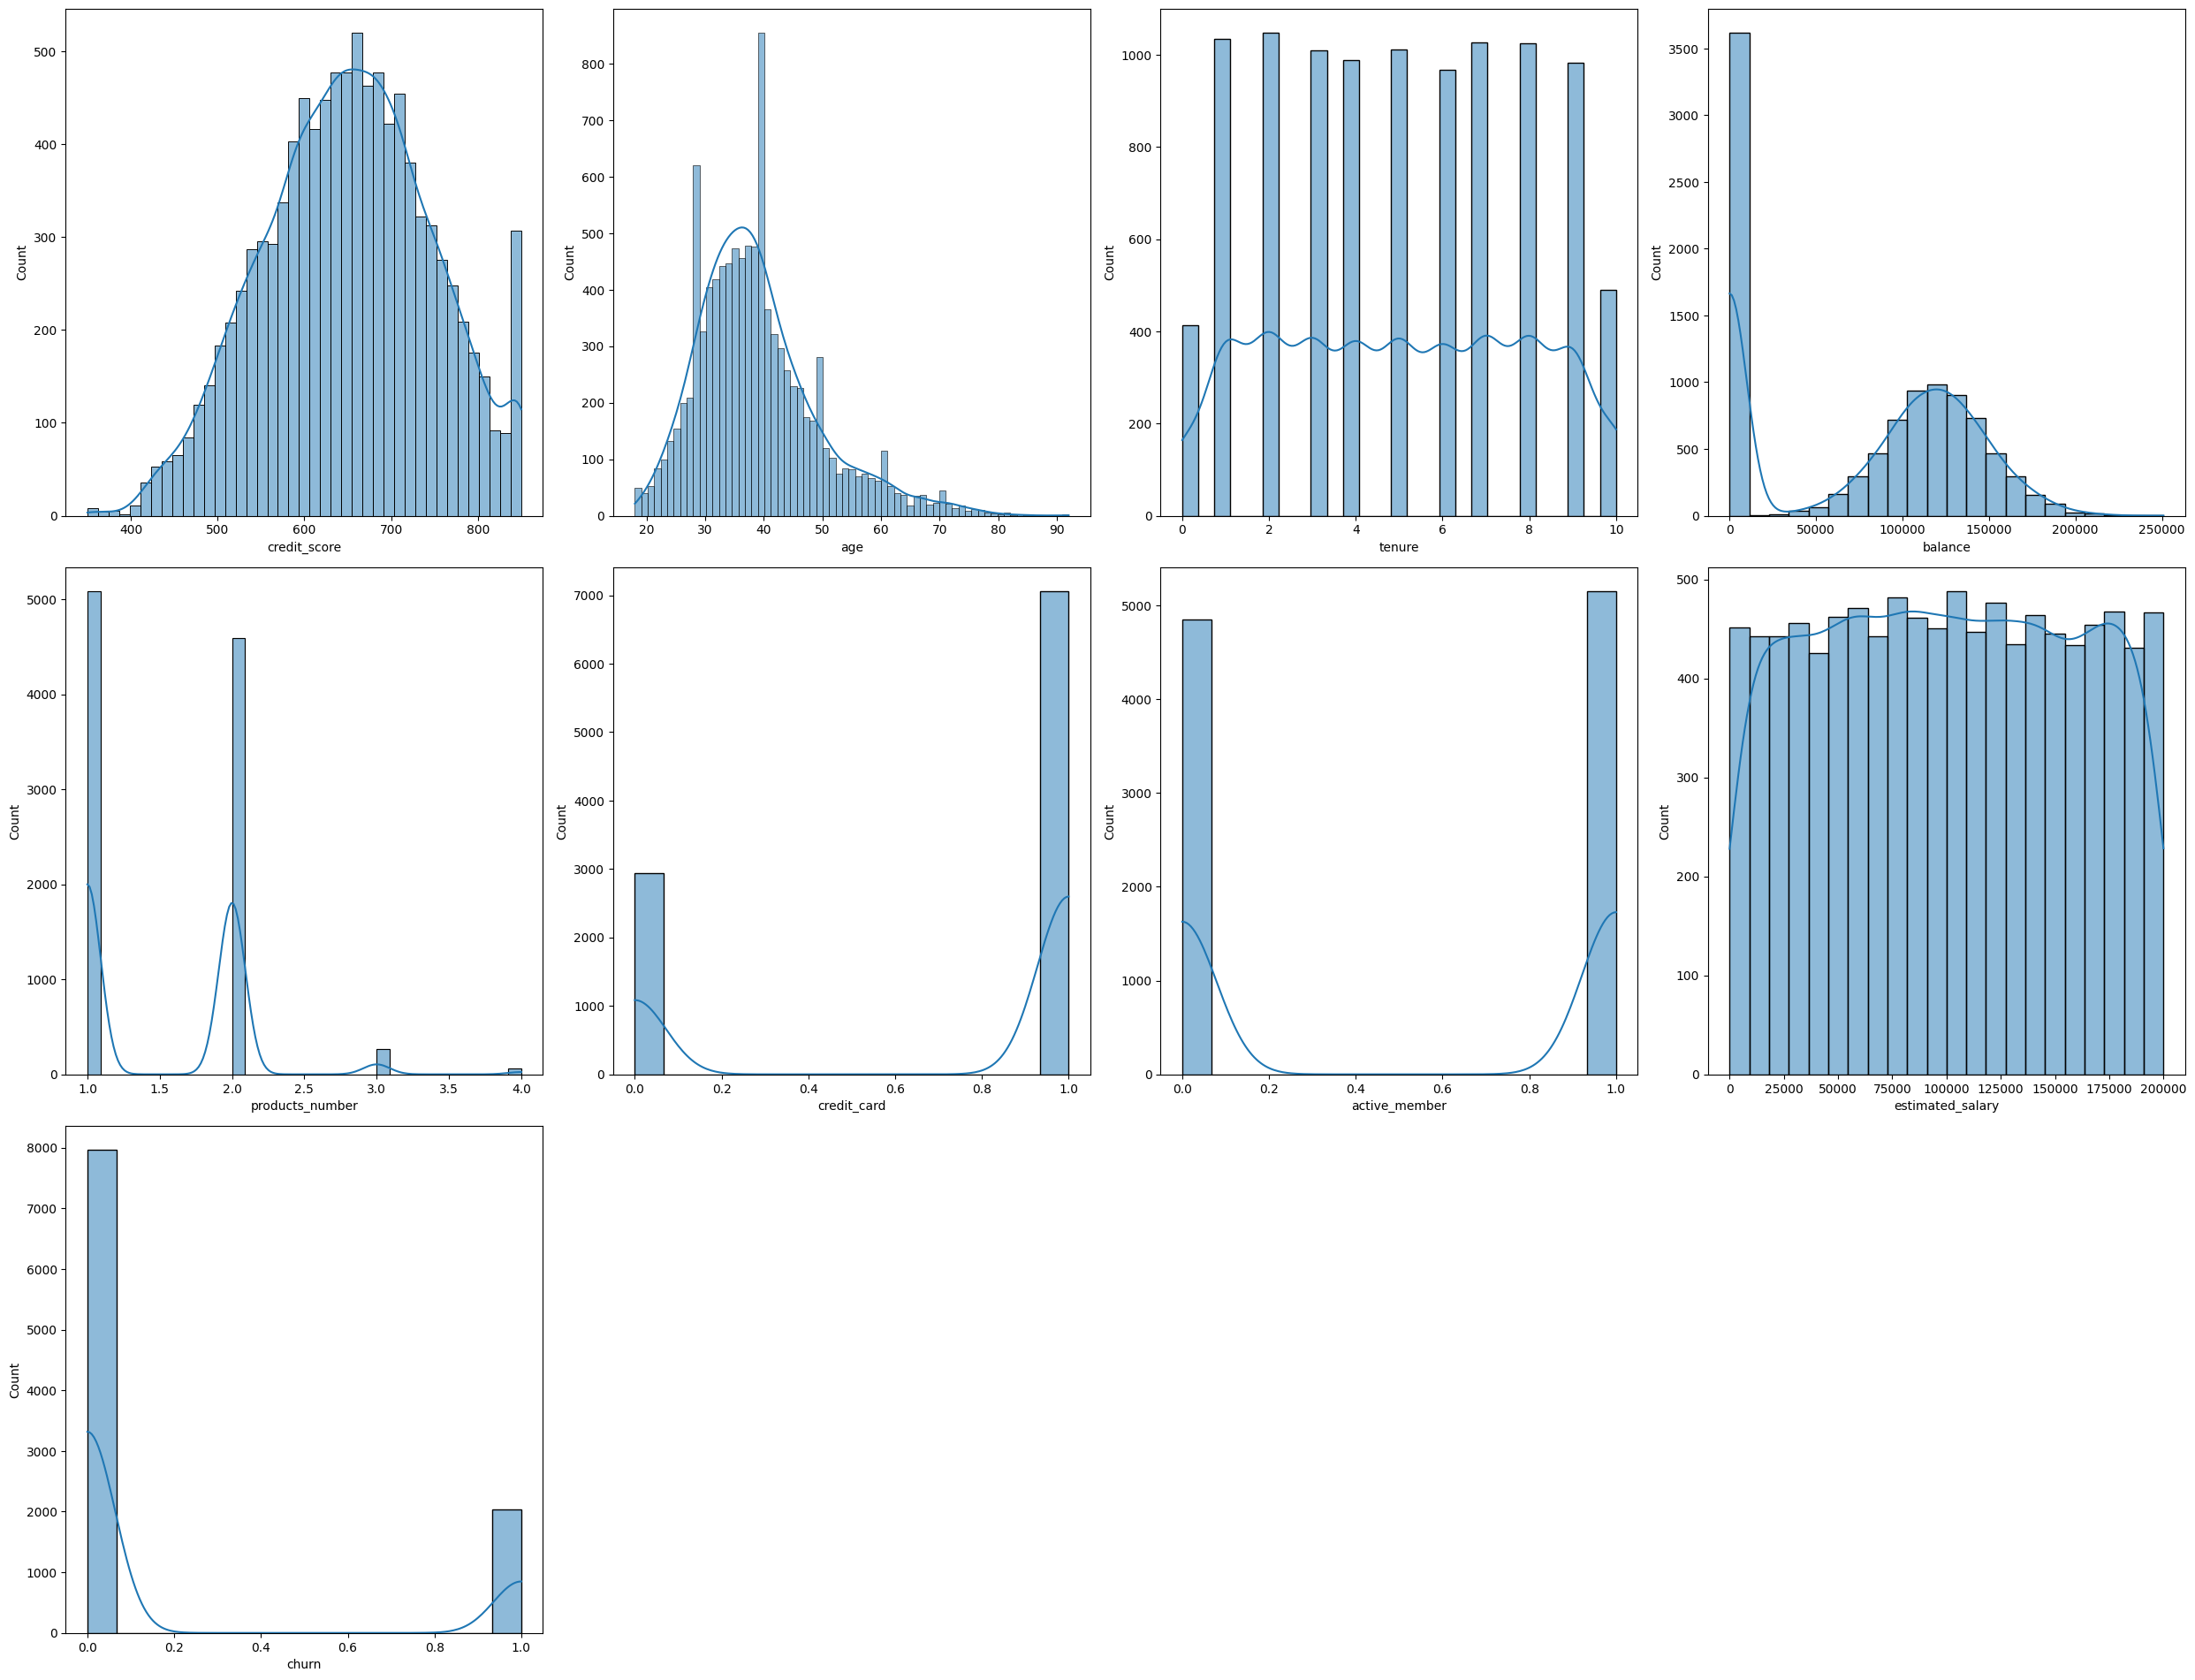

In [ ]:
rows = 4
cols = 4
counter = 1
plt.rcParams['figure.figsize'] = [25,25]
for row in range(rows):
    for col in range(cols):
        if counter <= len(num_cols):
            plt.subplot(rows, cols, counter)
            sns.histplot(df[num_cols[counter - 1]], kde=True)
        counter += 1
plt.tight_layout()
plt.show()

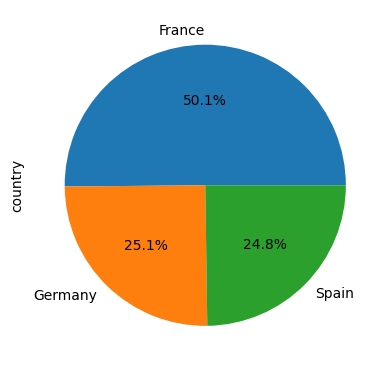

In [ ]:
df['country'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(4, 4))
plt.tight_layout()
plt.show()

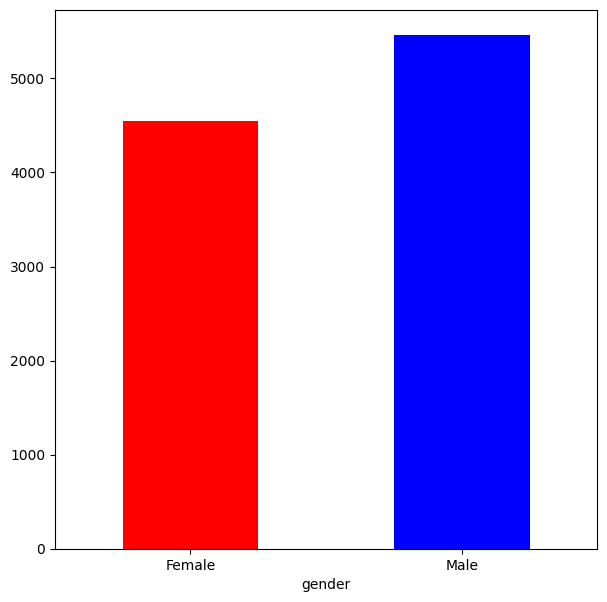

In [ ]:
#gender distribution
plt.figure(figsize = (7,7))
plt_room_types = df.groupby("gender").size().plot.bar(x="gender", y= 'size', rot = 0, color=['red', 'blue'])

# Encoding Categorical Features

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
onehot_col = ['country','gender']
onehot_prefix = ['cntry','gender']
df = pd.get_dummies(df, columns=onehot_col, prefix = onehot_prefix)
for col in catg_cols:
  if col not in onehot_col:
    df[col] = LabelEncoder().fit_transform(df[col])

# Q1. Is the relationship significant?
The correlation matrix shows the relationships between the different attributes of our data set.

We can see that many variables have relationships with other variables as well.

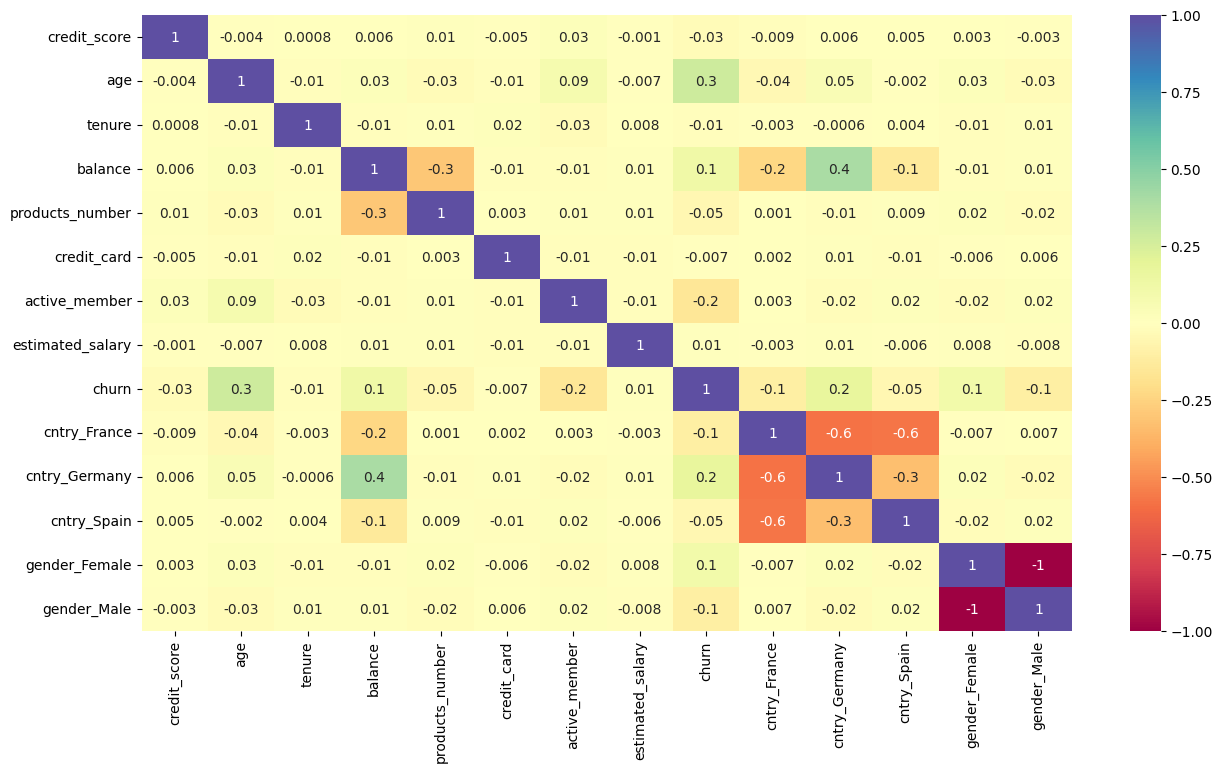

In [ ]:
plt.rcParams['figure.figsize']=[15, 8]
sns.heatmap(df.corr(),  annot = True ,fmt = '.1g', vmin = -1, vmax = 1, center = 0, cmap = 'Spectral');

<Axes: >

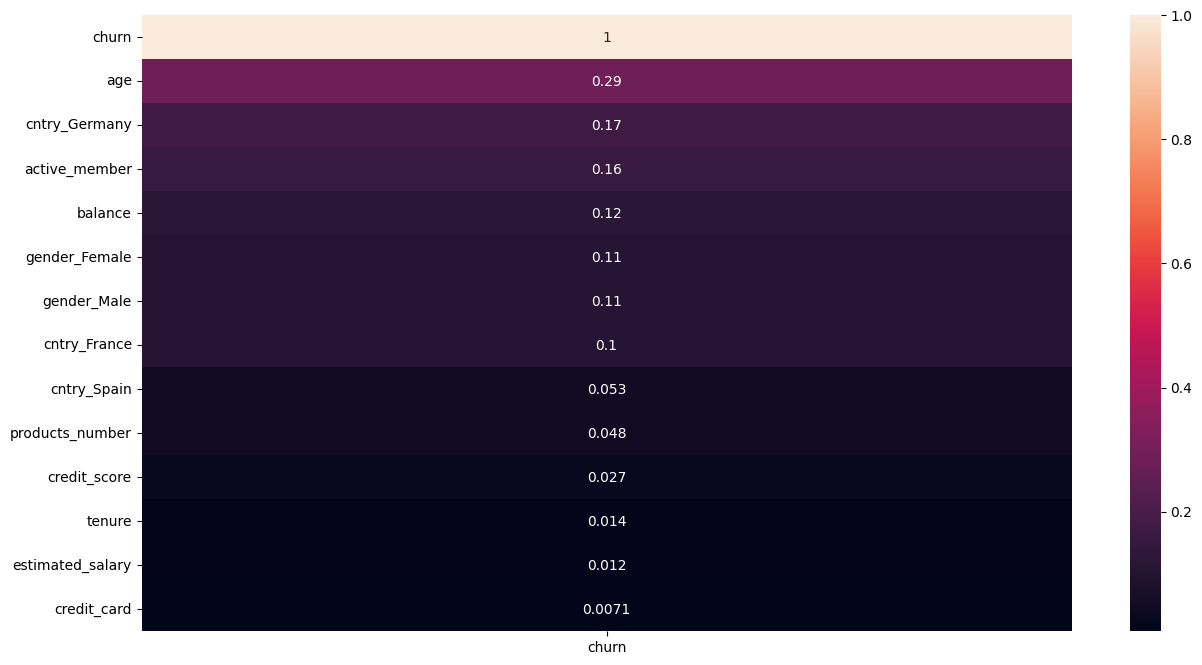

In [ ]:
corr=df.corr()["churn"]
corr=corr.abs().sort_values(ascending=False)
sns.heatmap(data=corr.to_frame(),annot=True)

The most important variables are listed at the top of the heatmap, based on the absolute value of their correlation coefficient. In this case, the top variables are:

cntry_Germany (0.17)

gender_Female (0.6)

churn (0.54)

age (0.29)

cntry_France (0.1)

active_member (0.16)

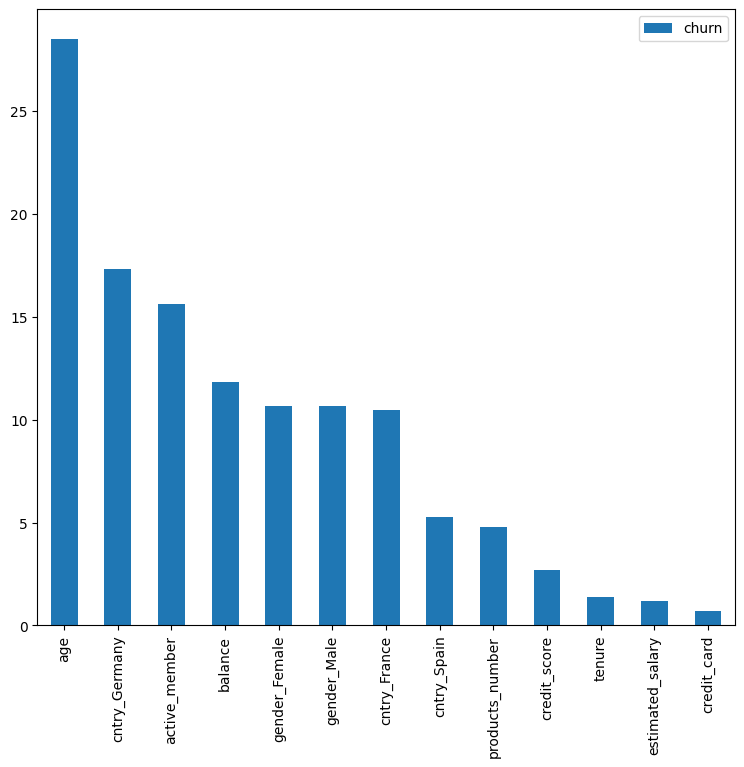

In [ ]:
pd.DataFrame(abs(df.corr()['churn'].drop(['churn'])*100).sort_values(ascending=False)).plot.bar(figsize = (9,8));

# Q2. Are any model assumptions violated?

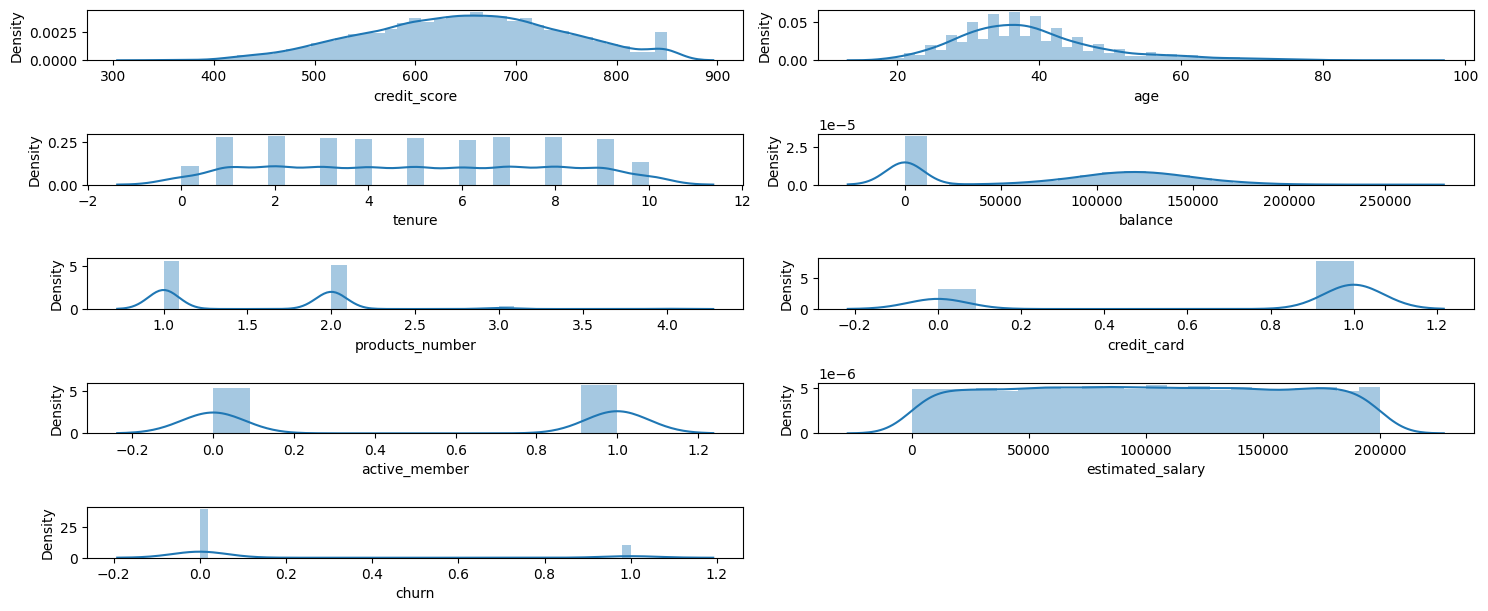

In [ ]:
# Generating Distribution plots
rows=10
cols=2
#Set counter variable to 1, to keeptrack of which subplot is being plotted in the loop
counter=1
plt.rcParams['figure.figsize']=[15, 12]
for i in num_cols:
    plt.subplot(rows, cols, counter)
    sns.distplot(df[i])
    counter+=1
#subplots are properly spaced and aligned
plt.tight_layout()
plt.show()

Yes, model assumptions have been violated.

Linear Regression Model assumes that the independent variables follow a normal distribution.

Credit score and estimated salary are normally distributed

Whereas other columns such as balance is Right-Skewed.

Hence, violating model assumptions.

It is possible that due to outliers in the dataset the distributions are not properly distributed. We should replot them after eliminating the outliers.

# Removing outliers

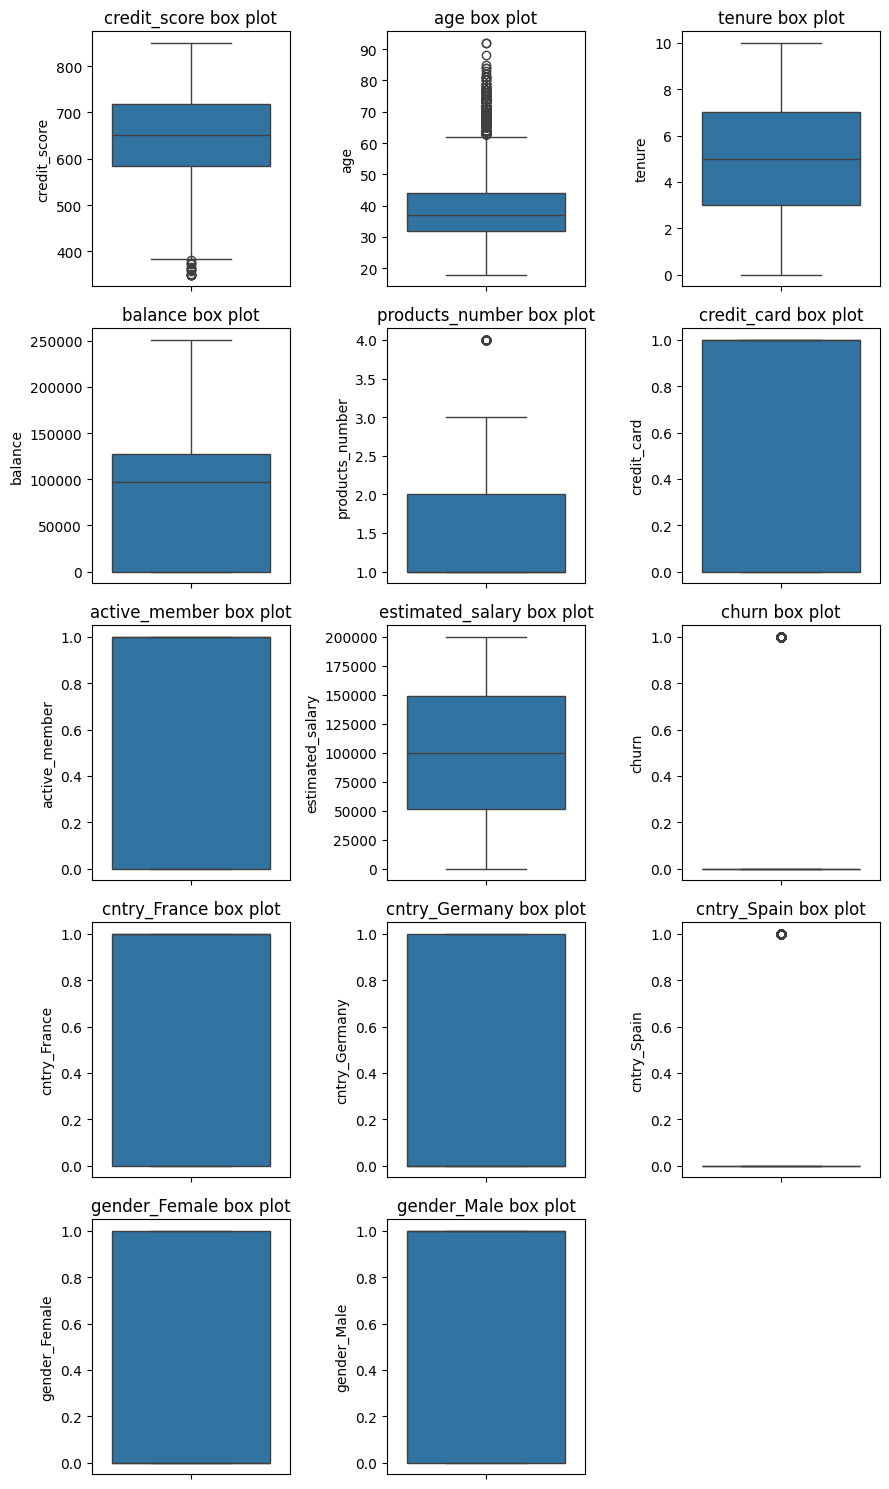

In [ ]:
cols=3
rows=((len(df.columns)-1) // cols)+1
counter=1
plt.rcParams['figure.figsize']=[3*cols, 3*rows]
for c in df.columns:
    plt.subplot(rows, cols, counter)
    sns.boxplot(df[c])
    plt.title("{} box plot".format(c), size=12)
    counter+=1
plt.tight_layout()
plt.show()

<Axes: >

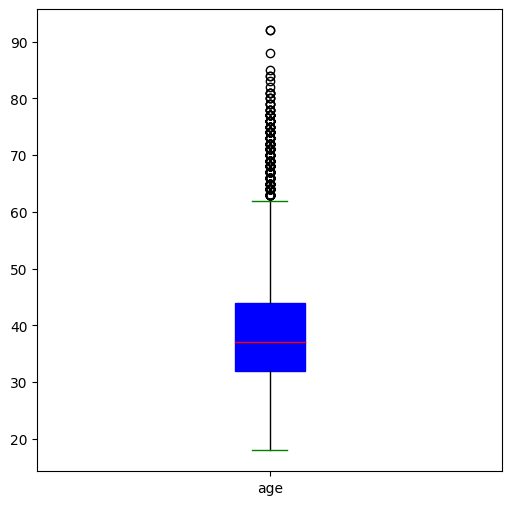

In [ ]:
age=df['age']
plt.figure(figsize=(6,6))
props2= dict(boxes='blue',whiskers='black',medians='red',caps='green')
age.plot.box(color=props2,patch_artist=True,vert=True)

In [ ]:
def find_boundaries(df,feature):
    Q1=df[feature].quantile(.25)
    Q3=df[feature].quantile(.75)
    IQR=Q3-Q1
    lower_boundary=Q1-1.5*IQR
    upper_boundary=Q3+1.5*IQR

    return lower_boundary,upper_boundary

In [ ]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [ ]:
def remove_outlier(df_in,feature):
    Q1=df_in[feature].quantile(.25)
    Q3=df_in[feature].quantile(.75)
    IQR=Q3-Q1
    lower_boundary=Q1-1.5*IQR
    upper_boundary=Q3+1.5*IQR
    df_out=df_in.loc[(df_in[feature]>lower_boundary) & (df_in[feature]<upper_boundary)]

    return df_out

In [ ]:
lower_age,upper_age=find_boundaries(df,'age')
print(lower_age,upper_age)

14.0 62.0


In [ ]:
outliers = find_outliers_IQR(df['age'])
print('number of outliers: '+ str(len(outliers)))

number of outliers: 359


In [ ]:
df= remove_outlier(df,'age')

<Axes: >

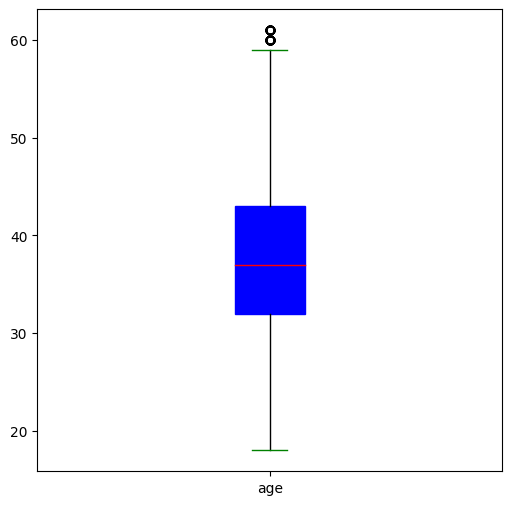

In [ ]:
age=df['age']
plt.figure(figsize=(6,6))
props2= dict(boxes='blue',whiskers='black',medians='red',caps='green')
age.plot.box(color=props2,patch_artist=True,vert=True)

<Axes: >

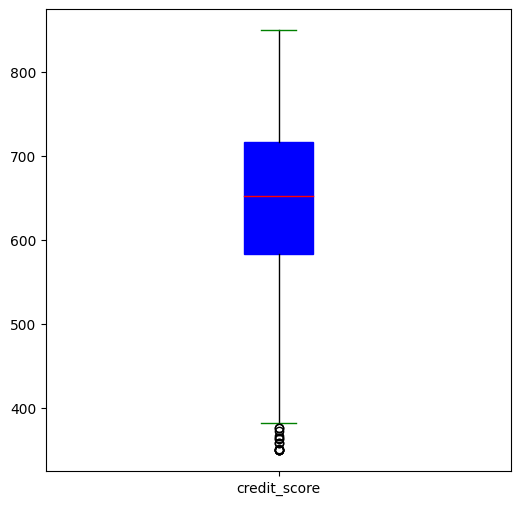

In [ ]:
credit_score=df['credit_score']
plt.figure(figsize=(6,6))
props2= dict(boxes='blue',whiskers='black',medians='red',caps='green')
credit_score.plot.box(color=props2,patch_artist=True,vert=True)

In [ ]:
lower_credit_score,upper_credit_score=find_boundaries(df,'credit_score')
print(lower_credit_score,upper_credit_score)

outliers = find_outliers_IQR(df['credit_score'])
print('number of outliers: '+ str(len(outliers)))

382.0 918.0
number of outliers: 14


In [ ]:
df= remove_outlier(df,'credit_score')

<Axes: >

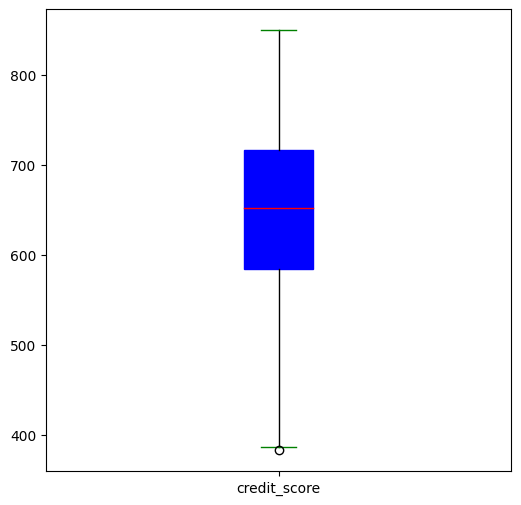

In [ ]:
credit_score=df['credit_score']
plt.figure(figsize=(6,6))
props2= dict(boxes='blue',whiskers='black',medians='red',caps='green')
credit_score.plot.box(color=props2,patch_artist=True,vert=True)

# Plotting The Columns After Removing Outliers

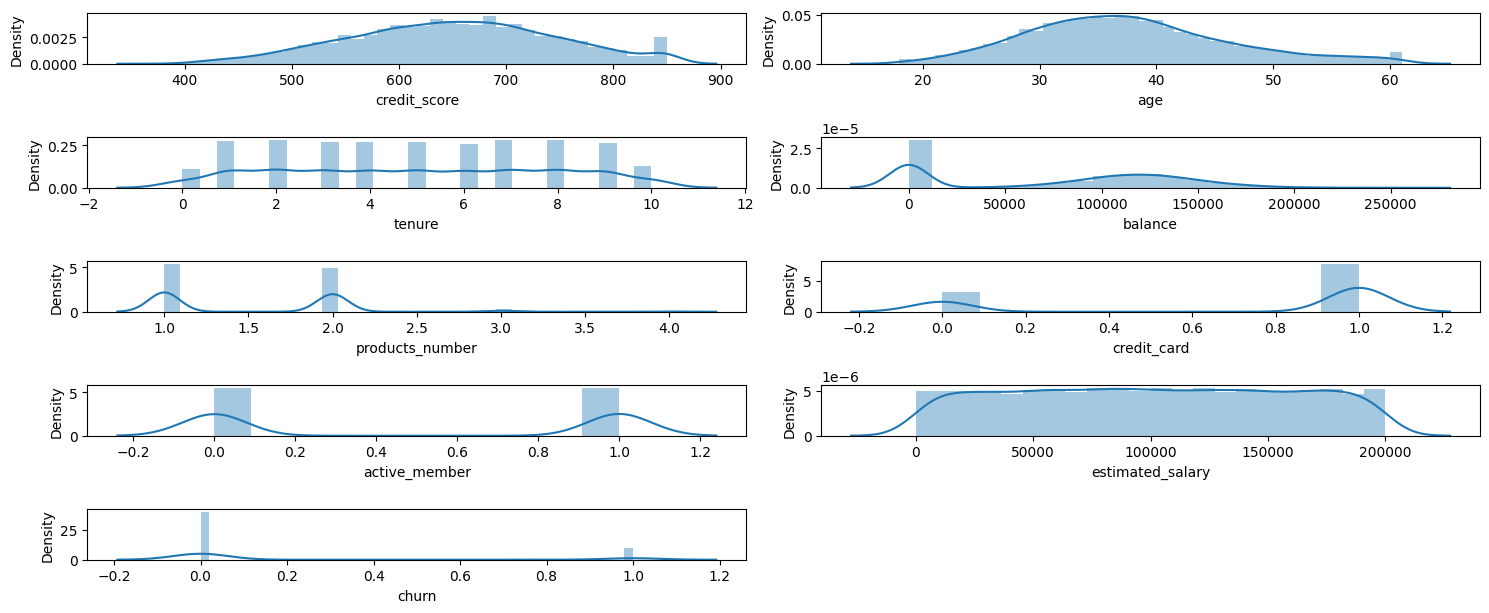

In [ ]:
# Generating Distribution plots
rows=10
cols=2
#Set counter variable to 1, to keeptrack of which subplot is being plotted in the loop
counter=1
plt.rcParams['figure.figsize']=[15, 12]
for i in num_cols:
    plt.subplot(rows, cols, counter)
    sns.distplot(df[i])
    counter+=1
#subplots are properly spaced and aligned
plt.tight_layout()
plt.show()

After removing the outliers, the independent variables have distribution more like Normal.

# Q3. Is there any multicollinearity in the model?

In [ ]:
numeric_cols = df.select_dtypes(exclude = "object").columns

vif_df = df[numeric_cols]
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [variance_inflation_factor(vif_df.values ,i) for i in range(len(vif_df.columns))]
vif_data.head(25)

feature       VIF
0       credit_score  1.001121
1                age  1.155568
2             tenure  1.002149
3            balance  1.340006
4    products_number  1.124028
5        credit_card  1.001640
6      active_member  1.027048
7   estimated_salary  1.000901
8              churn  1.224836
9       cntry_France       inf
10     cntry_Germany       inf
11       cntry_Spain       inf
12     gender_Female       inf
13       gender_Male       inf

From the provided VIF results, it appears that there is no significant multicollinearity among the first eight features as their VIF values are close to 1.

However, the features related to country (cntry_France, cntry_Germany, and cntry_Spain) and gender (gender_Female and gender_Male) have infinite (inf) VIF values. This indicates perfect multicollinearity among these variables.

# Q4. In the multivariate models are predictor variables independent of all the other predictor variables?

No, from the heat map and the VIF result, we can see some predictor variables are highly related to other predictor variables

# H20 AutoML Execution

Creating H2O frame and split train / test data

In [ ]:
hdf = h2o.H2OFrame(df)
hdf.shape

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


(9574, 14)

In [ ]:
hdf.types

{'credit_score': 'int',
 'age': 'int',
 'tenure': 'int',
 'balance': 'real',
 'products_number': 'int',
 'credit_card': 'int',
 'active_member': 'int',
 'estimated_salary': 'real',
 'churn': 'int',
 'cntry_France': 'int',
 'cntry_Germany': 'int',
 'cntry_Spain': 'int',
 'gender_Female': 'int',
 'gender_Male': 'int'}

In [ ]:
hdf['churn'] = hdf['churn'].asfactor()

In [ ]:
# Create a 80/20 train/test split
pct_rows=0.80
hdf_train, hdf_test = hdf.split_frame([pct_rows])
print(hdf_train.shape)
print(hdf_test.shape)

(7678, 14)
(1896, 14)


In [ ]:
X=hdf.columns
print(X)

['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn', 'cntry_France', 'cntry_Germany', 'cntry_Spain', 'gender_Female', 'gender_Male']


In [ ]:
y_numeric ='churn'
X.remove(y_numeric)
print(X)

['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'cntry_France', 'cntry_Germany', 'cntry_Spain', 'gender_Female', 'gender_Male']


In [ ]:
# Set up AutoML
auml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [ ]:
#passing the data through H20AutoML
auml.train(x=X,y=y_numeric,training_frame=hdf_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_1_20240219_61553


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       4/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# DRF base models (used / total)           1/2
# DeepLearning base models (used / total)  1/1
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0871662986154292
RMSE: 0.29523939204555544
LogLoss: 0.2882600866093591
AUC: 0.9072618553197916
AUCPR: 0.7797470219191965
Gini: 0.8145237106395833
Null degrees of freedom: 7677
Residual degrees of freedom: 7673
Null deviance: 7745.87864135499
Residual deviance: 4426.521889973318
AIC: 4436.521889973318

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30404135176507996
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      5586  534   0.0873   (534.0/6120.0)
1      477   1081  0.3062   (477.0/1558.0)
Total  6063  1615  0.1317   (1011.0/7678.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304041     0.681374  202
max f2                       0.150001     0.748179  275
max f0point5                 0.576354     0.74909   118
max accuracy                 0.483851     0.882912  144
max precision                0.993225     1         0
max recall                   0.0145964    1         390
max specificity              0.993225     1         0
max absolute_mcc             0.379935     0.605468  176
max min_per_class_accuracy   0.188361     0.821242  254
max mean_per_class_accuracy  0.202998     0.822204  247
max tns                      0.993225     6120      0
max fns                      0.993225     1553      0
max fps                      0.00654893   6120      399
max tps                      0.0145964    1558      390
max tnr                      0.993225     1         0
max fnr                      0.993225     0.996791  0
max fpr                      0.00654893   1         399
max tpr                      0.0145964    1         390

Gains/Lift Table: Avg response rate: 20.29 %, avg score: 20.17 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100287                   0.968017           4.92811     4.92811            1                0.978473   1                           0.978473            0.0494223       0.0494223                  392.811   392.811            0.0494223
2        0.0200573                   0.949083           4.92811     4.92811            1                0.958698   1                           0.968585            0.0494223       0.0988447                  392.811   392.811            0.0988447
3        0.030086                    0.920008           4.92811     4.92811            1                0.934814   1                           0.957328            0.0494223       0.148267                   392.811   392.811            0.148267
4      

# Generating Leaderboard for Best Model

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                     auc    logloss     aucpr    mean_per_class_error      rmse        mse    training_time_ms    predict_time_per_row_ms  algo
------------------------------------------------------  --------  ---------  --------  ----------------------  --------  ---------  ------------------  -------------------------  ---------------
GBM_1_AutoML_1_20240219_61553                           0.878347   0.320536  0.698158                0.223226  0.312865  0.0978846                2049                   0.016655  GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20240219_61553  0.878184   0.319825  0.698329                0.198989  0.312667  0.0977607                1466                   0.024794  StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20240219_61553     0.877779   0.319254  0.702865                0.231579  0.31234   0.0975562                1734                   0.167154  StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_1_20240219_61553  0.877518   0.319797  0.700118                0.2134    0.312722  0.0977948                 774                   0.052684  StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20240219_61553     0.876776   0.319959  0.701301                0.227403  0.312779  0.097831                 1511                   0.090073  StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20240219_61553  0.876      0.32126   0.698299                0.23117   0.313544  0.0983098                 909                   0.102442  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20240219_61553     0.875679   0.321312  0.700986                0.213032  0.313126  0.0980478                1225                   0.14614   StackedEnsemble
GBM_grid_1_AutoML_1_20240219_61553_model_2              0.875677   0.324326  0.691421                0.227813  0.314171  0.0987036                1059                   0.014217  GBM
GBM_grid_1_AutoML_1_20240219_61553_model_3              0.874459   0.324102  0.696694                0.237025  0.314147  0.0986886                 565                   0.024338  GBM
StackedEnsemble_BestOfFamily_2_AutoML_1_20240219_61553  0.873147   0.323829  0.69541                 0.233095  0.314501  0.0989112                 874                   0.04466   StackedEnsemble
XGBoost_grid_1_AutoML_1_20240219_61553_model_3          0.870826   0.324399  0.694587                0.219133  0.314949  0.0991926                 969                   0.009081  XGBoost
GBM_5_AutoML_1_20240219_61553                           0.870213   0.328758  0.681321                0.235142  0.316629  0.100254                  622                   0.021702  GBM
XGBoost_3_AutoML_1_20240219_61553                       0.86989    0.326021  0.690032                0.22204   0.315721  0.0996797                 868                   0.007578  XGBoost
GBM_2_AutoML_1_20240219_61553                           0.869833   0.327113  0.689329                0.21029   0.315692  0.0996615                 921                   0.021938  GBM
GBM_3_AutoML_1_20240219_61553                           0.869119   0.328773  0.686711                0.219583  0.316624  0.100251                  786                   0.028513  GBM
XGBoost_grid_1_AutoML_1_20240219_61553_model_7          0.867835   0.32774   0.687048                0.229574  0.316381  0.100097                  859                   0.006245  XGBoost
DeepLearning_1_AutoML_1_20240219_61553                  0.86737    0.330854  0.6786                  0.234733  0.318643  0.101533                  785                   0.008297  DeepLearning
XGBoost_grid_1_AutoML_1_20240219_61553_model_2          0.865749   0.330277  0.686023                0.232604  0.317473  0.100789                  759                   0.00934   XGBoost
XGBoost_1_AutoML_1_20240219_61553                       0.864604   0.335544  0.672557                0.237149  0.32071   0.102855                 2371                   0.008641  XGBoost
XGBoost_grid_1_AutoML_1_2024021

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_4_AutoML_1_20240219_61553

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27308626640892575
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      1349  177  0.116    (177.0/1526.0)
1      115   255  0.3108   (115.0/370.0)
Total  1464  432  0.154    (292.0/1896.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

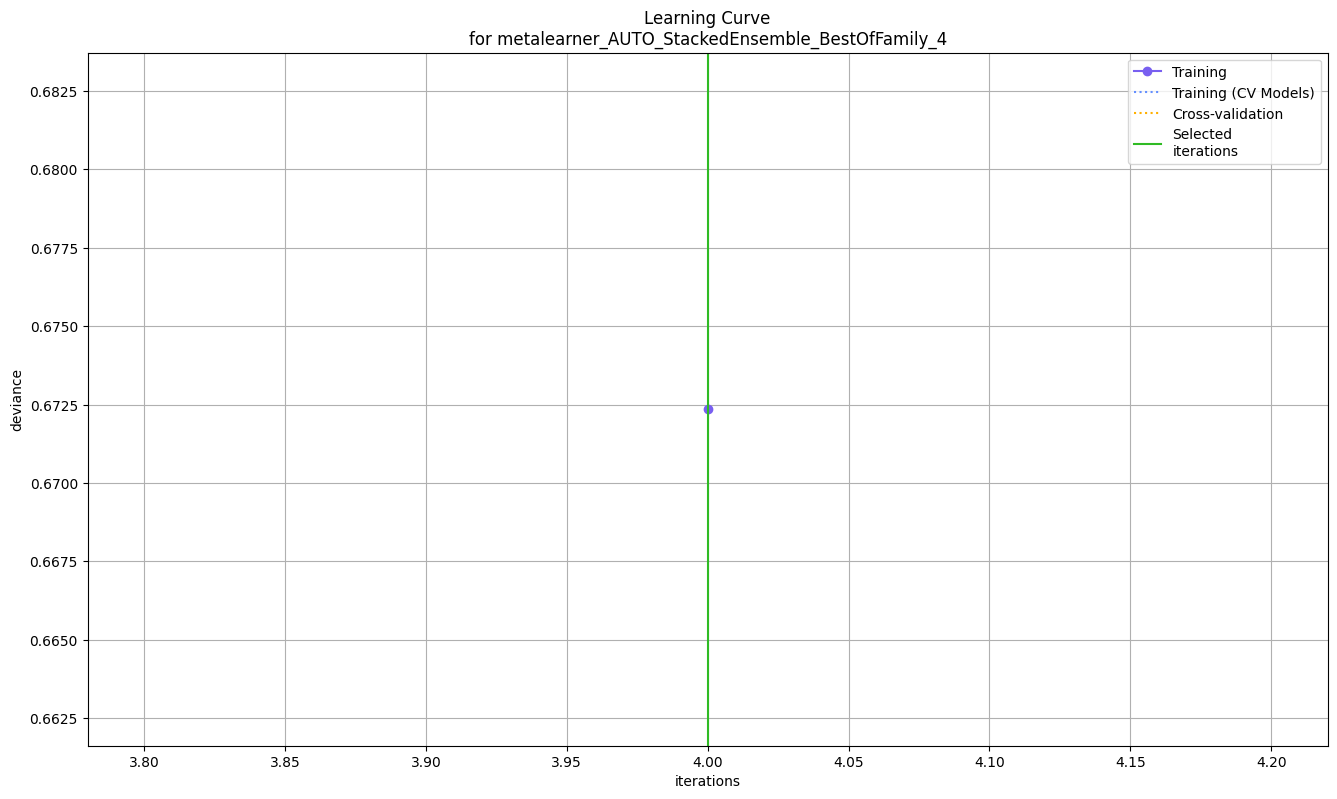

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

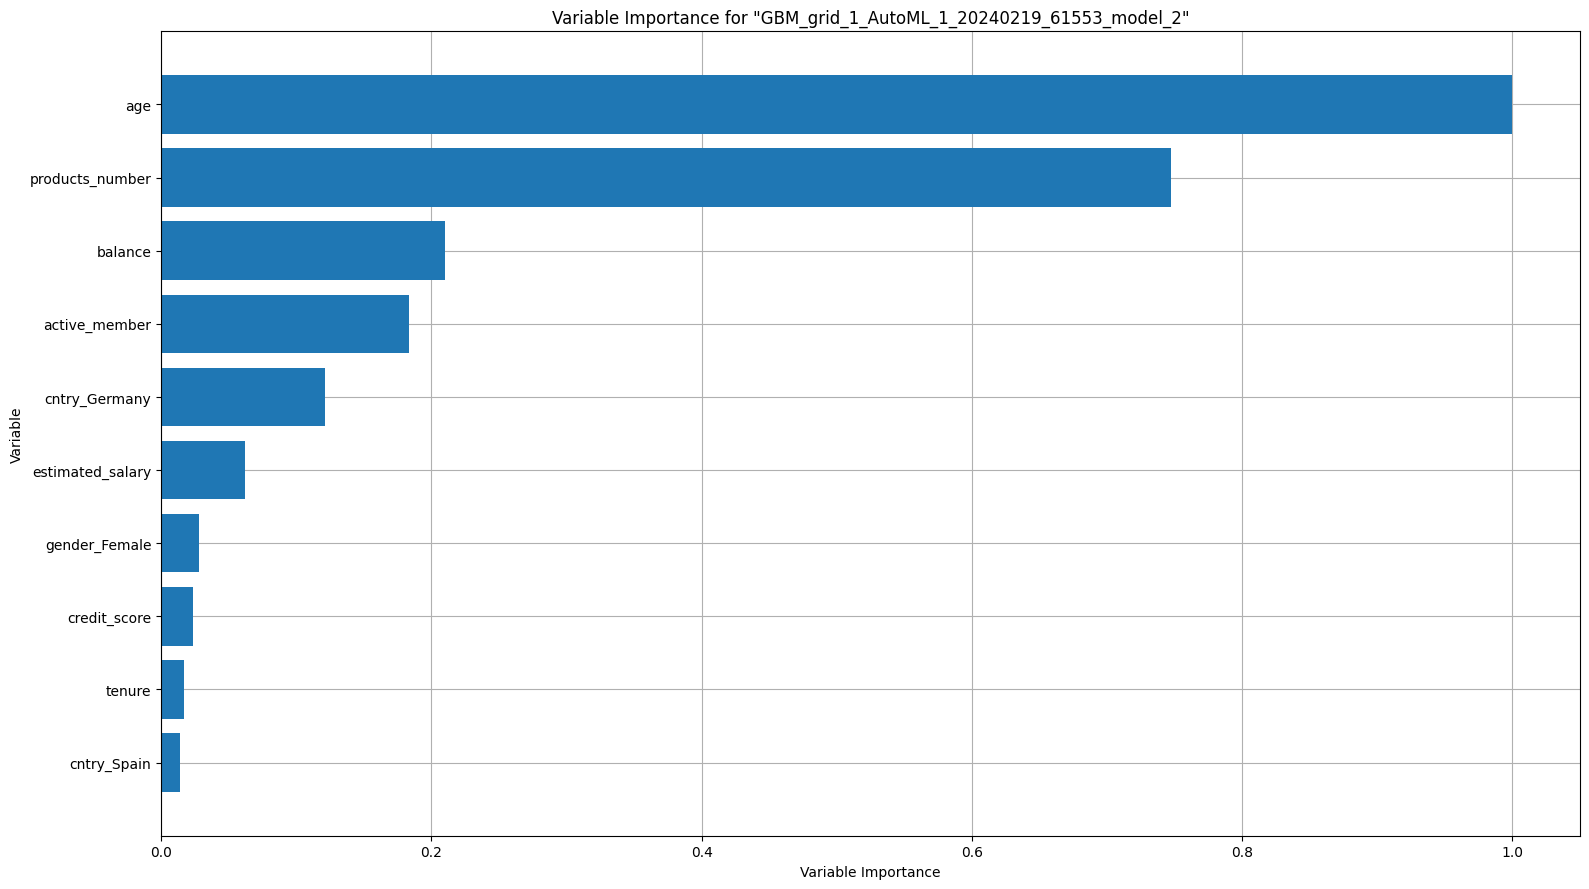

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

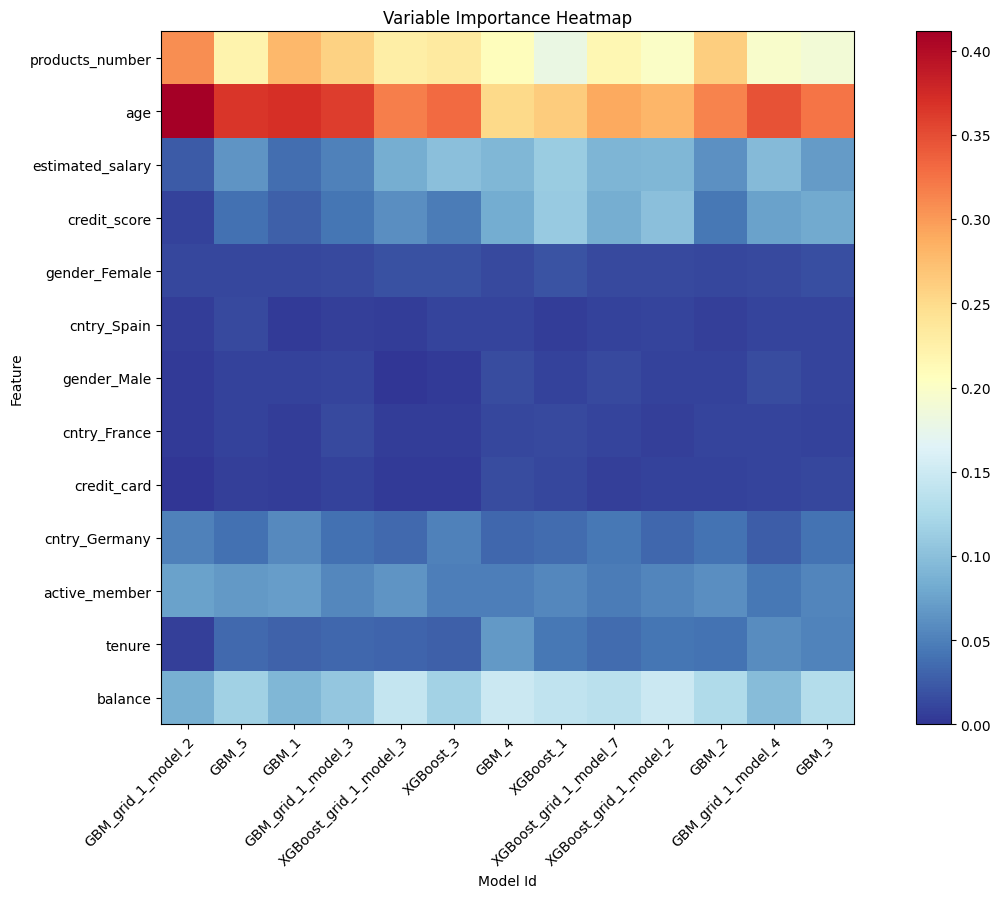

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

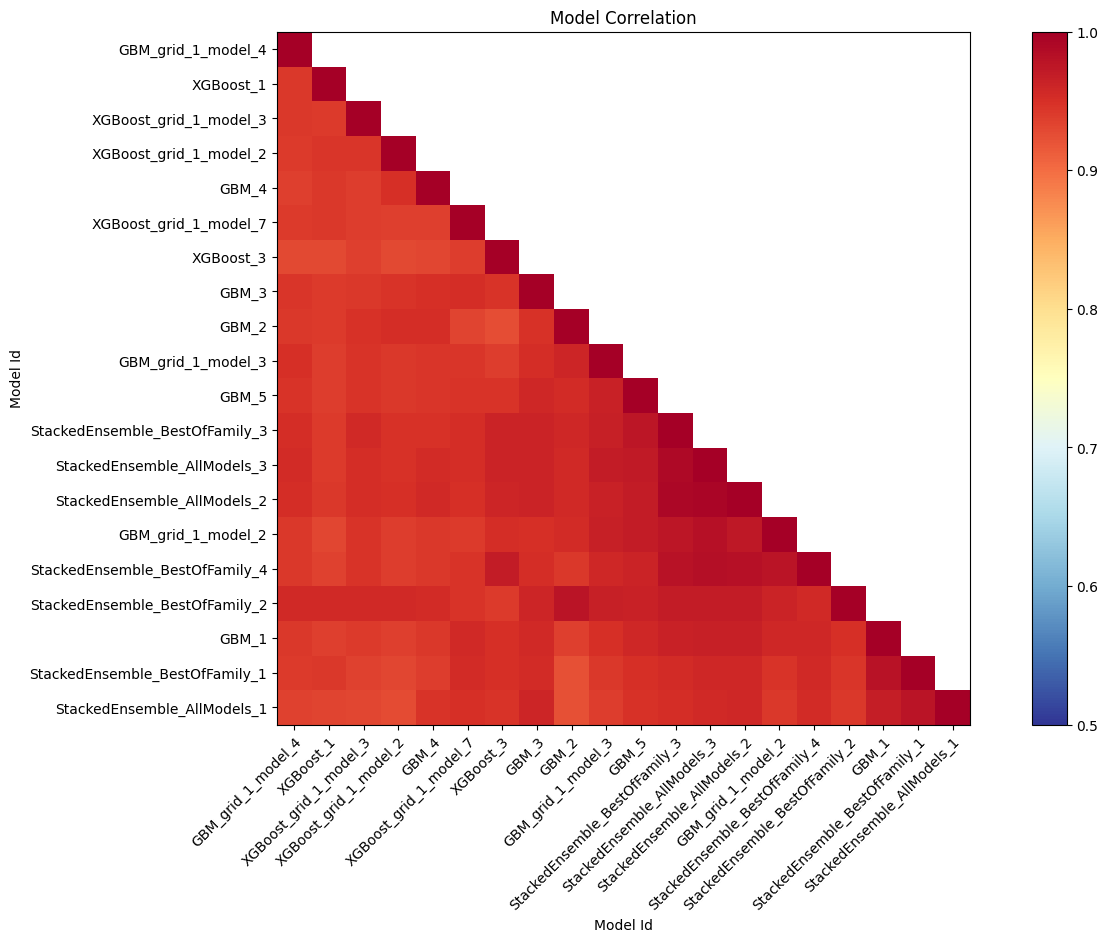

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

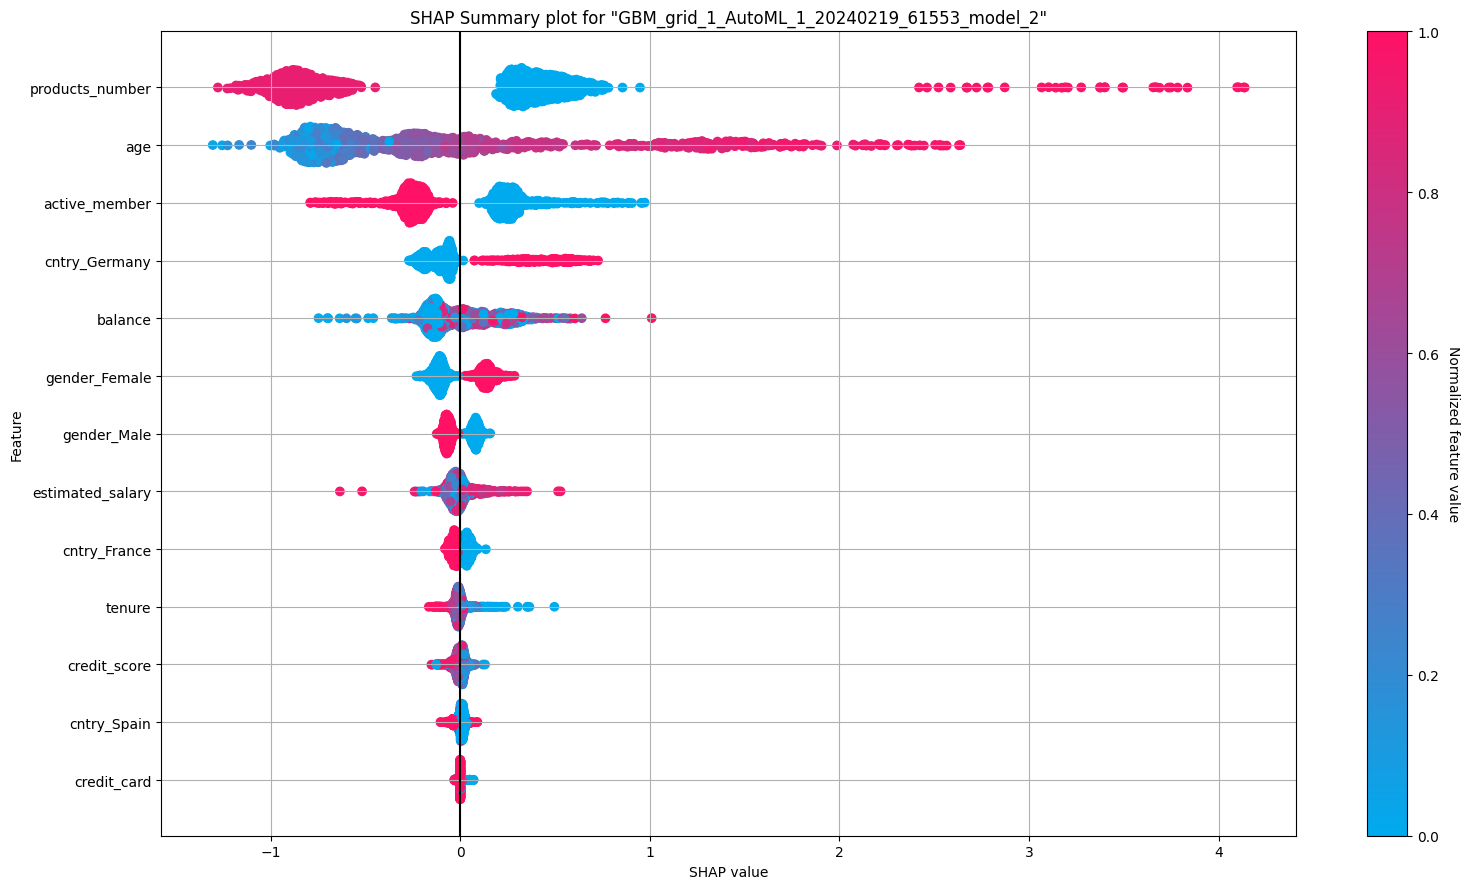

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

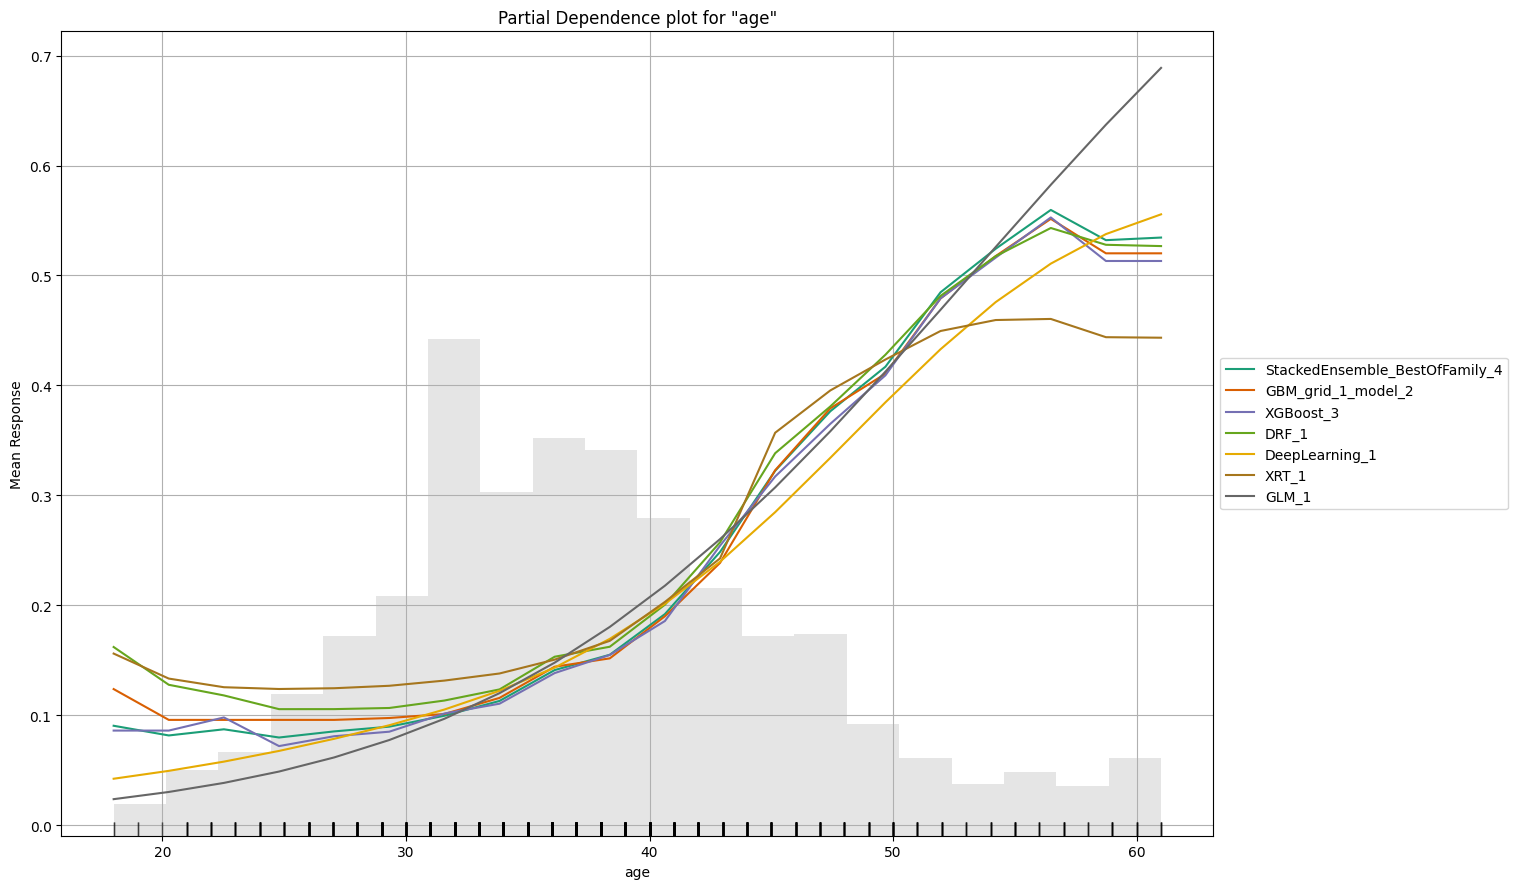

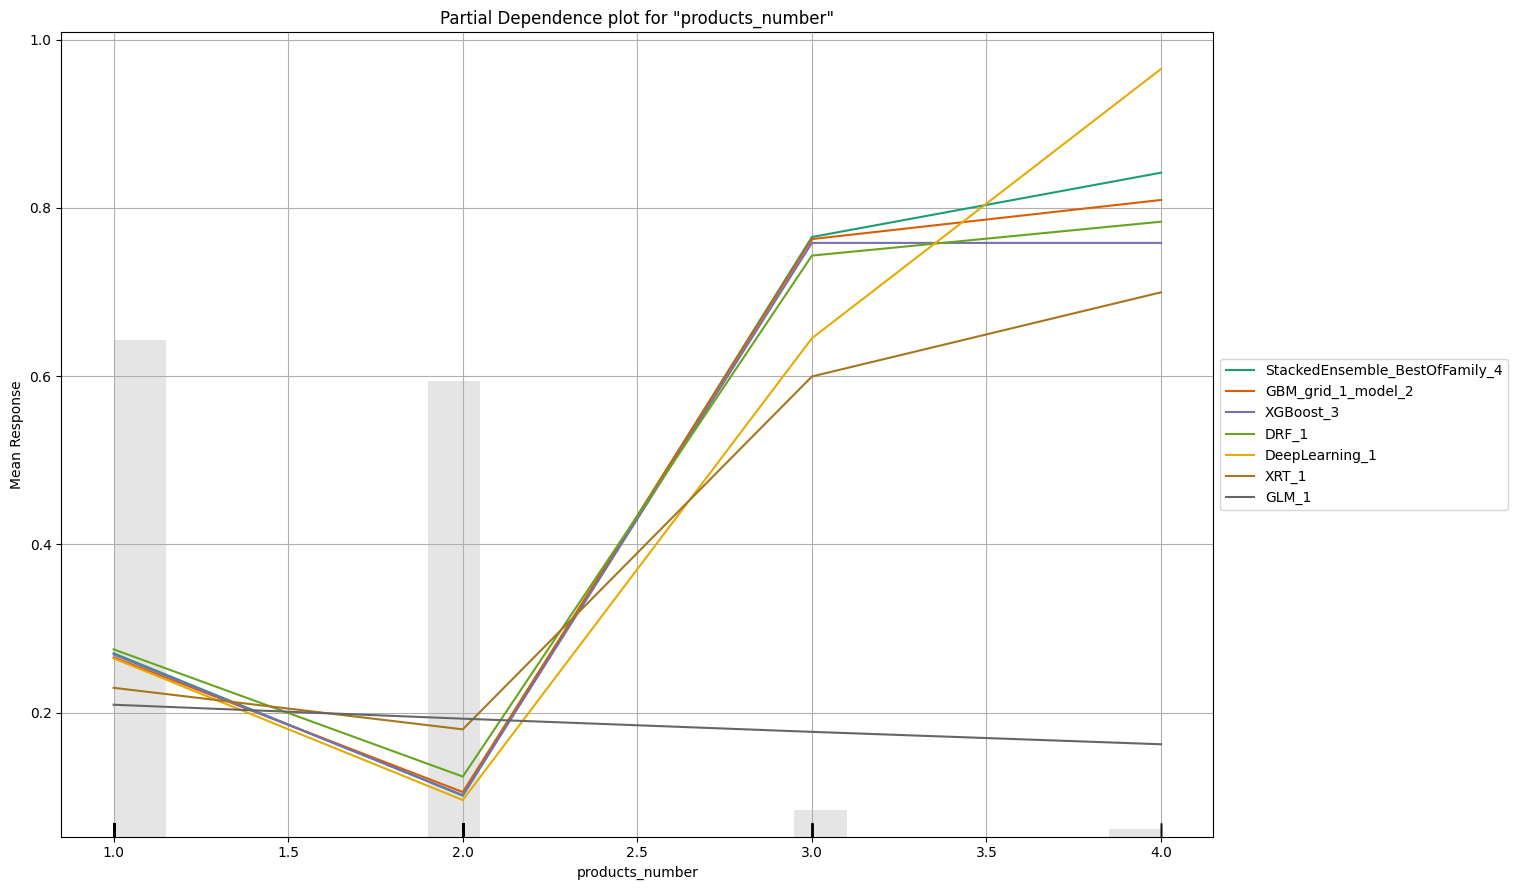

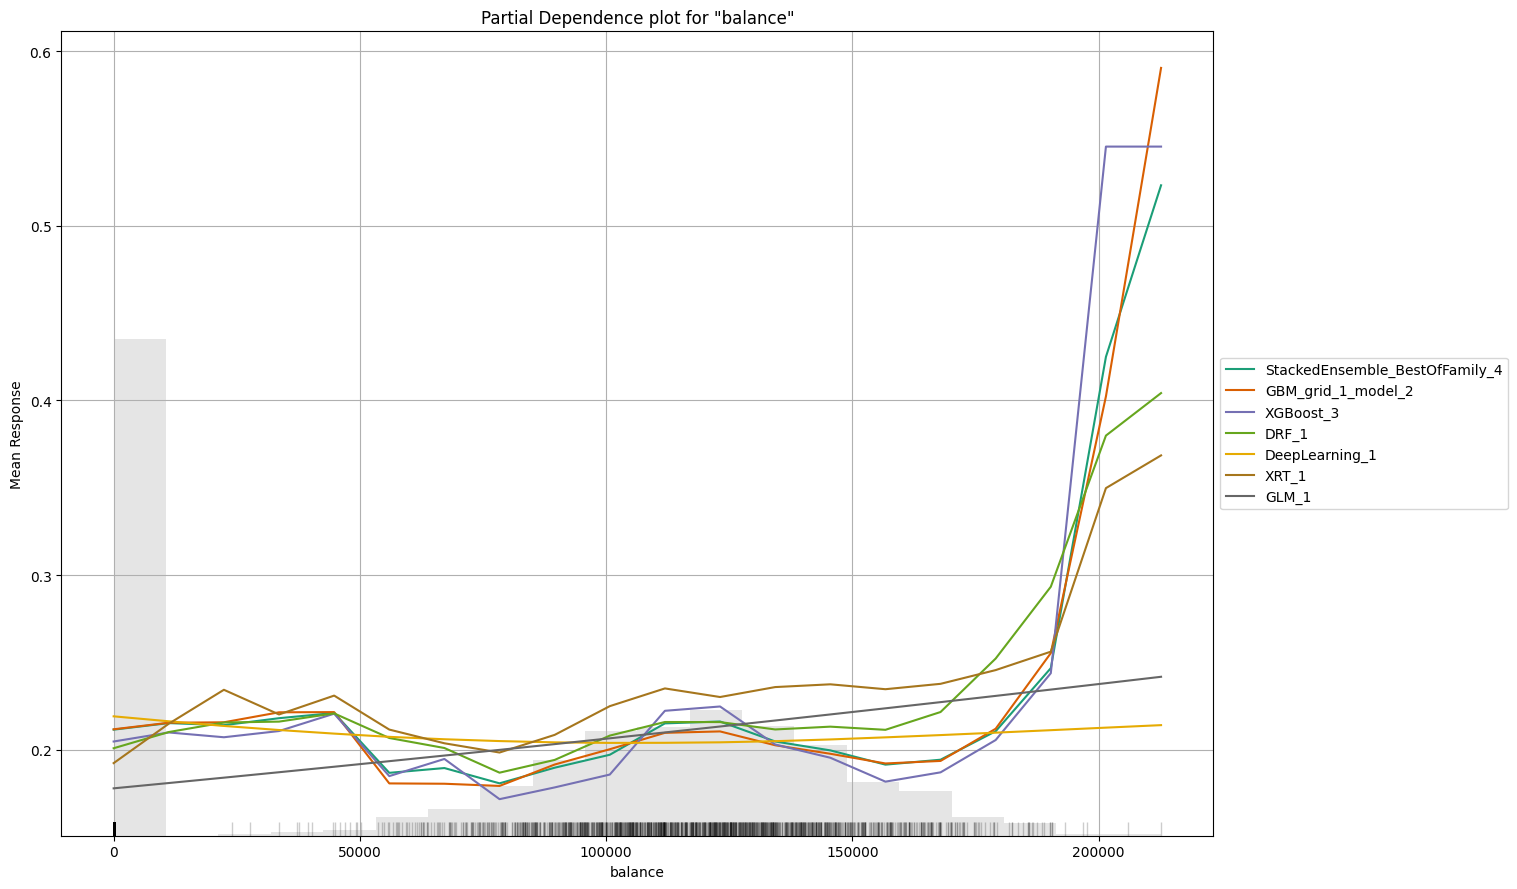

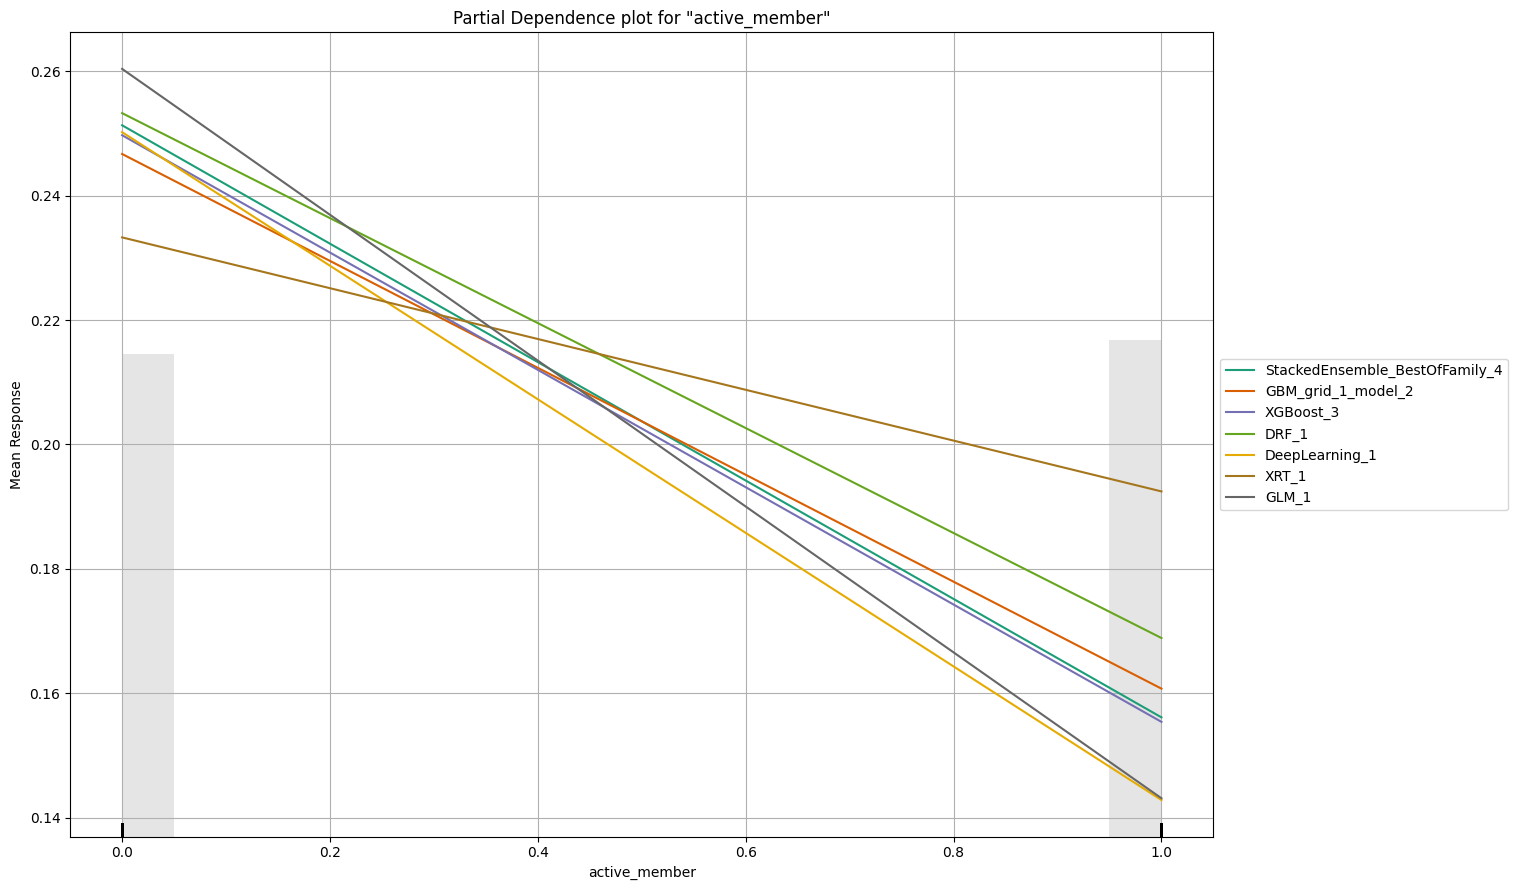

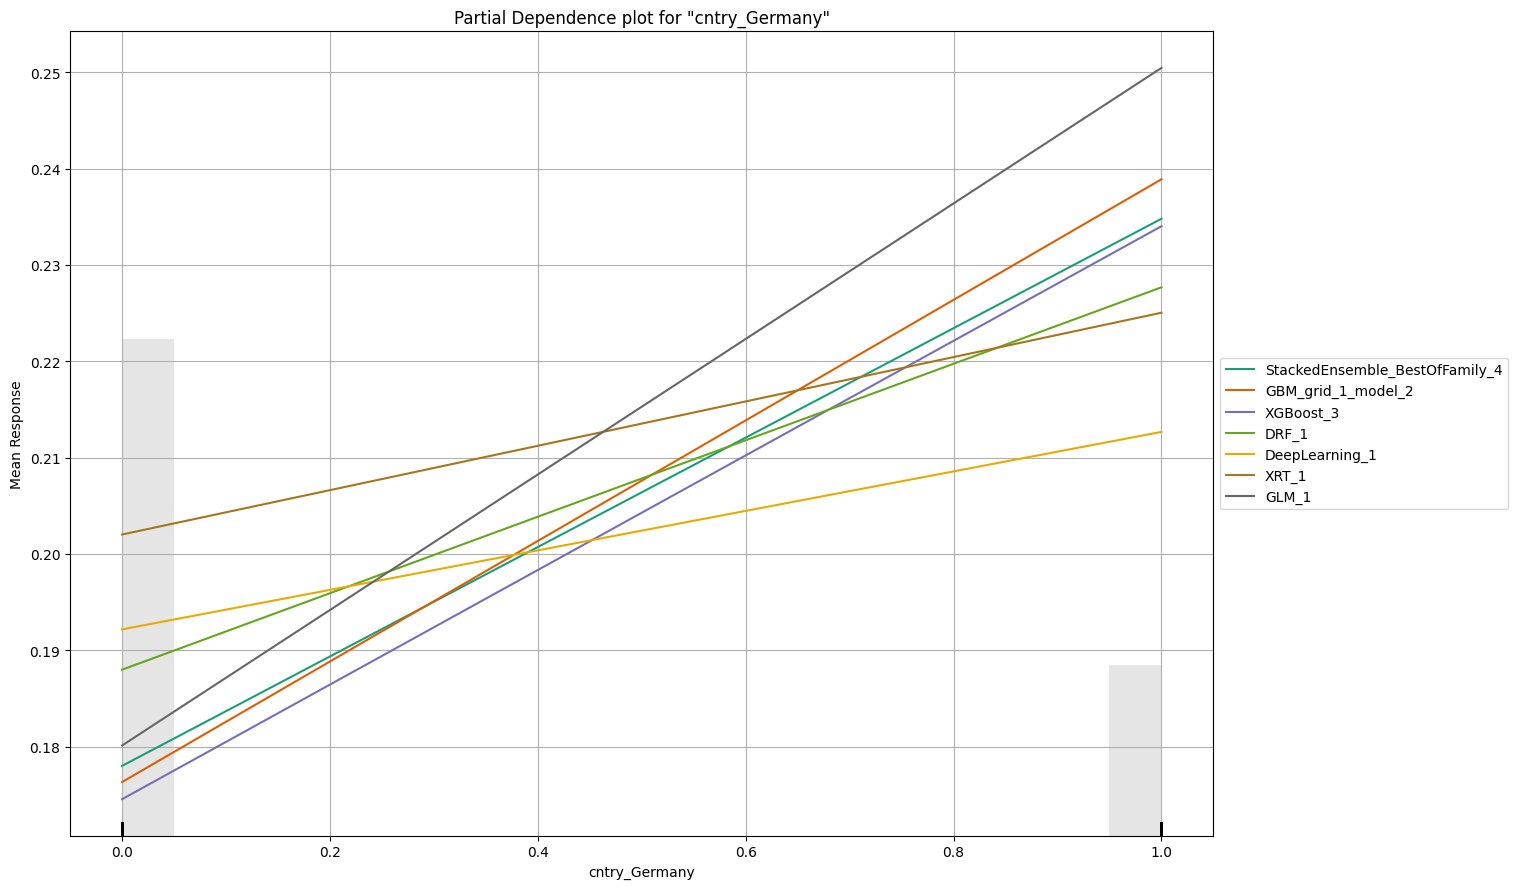

In [ ]:
exa = auml.explain(hdf_test)

# Q5. In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model

In [ ]:
#Compute VIF for all columns except target variable
Multic = df[X]
#Compute VIF
vif = pd.DataFrame()
vif["variables"] = Multic.columns
vif["VIF"] = [variance_inflation_factor(Multic.values, i) for i in range(Multic.shape[1])]
vif

variables       VIF
0       credit_score  1.001005
1                age  1.007221
2             tenure  1.002029
3            balance  1.337833
4    products_number  1.123300
5        credit_card  1.001612
6      active_member  1.002521
7   estimated_salary  1.000816
8       cntry_France       inf
9      cntry_Germany       inf
10       cntry_Spain       inf
11     gender_Female       inf
12       gender_Male       inf

In [ ]:
results = smf.ols('churn ~ credit_score + age + tenure + balance + products_number + credit_card + active_member + estimated_salary + cntry_France + cntry_Spain + cntry_Germany + gender_Female + gender_Male', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  churn   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     195.4
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:21:10   Log-Likelihood:                -3866.1
No. Observations:                9574   AIC:                             7756.
Df Residuals:                    9562   BIC:                             7842.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1643      0.019     -8.601      0.000      -0.202      -0.127
credit_score     -4.061e-05   3.86e-05     -1.052      0.293      -0.000    3.51e-05
age                  0.0162      0.000     37.528      0.000       0.015       0.017
tenure              -0.0014      0.001     -1.068      0.285      -0.004       0.001
balance           2.707e-07   6.87e-08      3.942      0.000    1.36e-07    4.05e-07
products_number     -0.0168      0.007     -2.489      0.013      -0.030      -0.004
credit_card         -0.0042      0.008     -0.518      0.604      -0.020       0.012
active_member       -0.1135      0.007    -15.295      0.000      -0.128      -0.099
estimated_salary  5.818e-08   6.45e-08      0.903      0.367   -6.82e-08    1.85e-07
cntry_France        -0.0945      0.008    -12.372      0.000      -0.109      -0.079
cntry_Spain         -0.0943      0.009    -11.045      0.000      -0.111      -0.078
cntry_Germany        0.0244      0.010      2.537      0.011       0.006       0.043
gender_Female       -0.0461      0.010     -4.460      0.000      -0.066      -0.026
gender_Male         -0.1182      0.010    -11.624      0.000      -0.138      -0.098
==============================================================================
Omnibus:                     1406.491   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2113.491
Skew:                           1.139   Prob(JB):                         0.00
Kurtosis:                       3.334   Cond. No.                     1.10e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.55e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Calculating VIF and OLS for columns with VIF < 15 from above results

In [ ]:
#Indicate which variables to compute VIF (VIF < 15)
Multic = df[['credit_score', 'age', 'tenure', 'balance', 'products_number','credit_card','active_member','estimated_salary']]
#Compute VIF
vif = pd.DataFrame()
vif["variables"] = Multic.columns
vif["VIF"] = [variance_inflation_factor(Multic.values, i) for i in range(Multic.shape[1])]
vif

variables        VIF
0      credit_score  22.255289
1               age  15.372434
2            tenure   3.882060
3           balance   2.649412
4   products_number   7.803511
5       credit_card   3.295522
6     active_member   1.995979
7  estimated_salary   3.901061

In [ ]:
results = smf.ols('churn ~ credit_score + age + tenure + balance + products_number + credit_card + active_member + estimated_salary', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  churn   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     230.0
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:21:11   Log-Likelihood:                -3994.7
No. Observations:                9574   AIC:                             8007.
Df Residuals:                    9565   BIC:                             8072.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3791      0.035    -10.825      0.000      -0.448      -0.310
credit_score     -3.674e-05   3.91e-05     -0.939      0.348      -0.000    3.99e-05
age                  0.0166      0.000     38.114      0.000       0.016       0.017
tenure              -0.0015      0.001     -1.180      0.238      -0.004       0.001
balance           6.274e-07   6.32e-08      9.922      0.000    5.03e-07    7.51e-07
products_number     -0.0045      0.007     -0.657      0.511      -0.018       0.009
credit_card         -0.0027      0.008     -0.328      0.743      -0.019       0.013
active_member       -0.1166      0.008    -15.519      0.000      -0.131      -0.102
estimated_salary   6.73e-08   6.53e-08      1.030      0.303   -6.07e-08    1.95e-07
==============================================================================
Omnibus:                     1470.787   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2253.842
Skew:                           1.179   Prob(JB):                         0.00
Kurtosis:                       3.306   Cond. No.                     1.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Dropping Unwanted Variables

In [ ]:
df_new = df[['churn', 'credit_score', 'age', 'tenure', 'balance','products_number','credit_card','active_member','estimated_salary']].copy()
df_new.head()

churn  credit_score  age  tenure    balance  products_number  credit_card  \
0      1           619   42       2       0.00                1            1   
1      0           608   41       1   83807.86                1            0   
2      1           502   42       8  159660.80                3            1   
3      0           699   39       1       0.00                2            0   
4      0           850   43       2  125510.82                1            1   

   active_member  estimated_salary  
0              1         101348.88  
1              1         112542.58  
2              0         113931.57  
3              0          93826.63  
4              1          79084.10

In [ ]:
df_new.corr()

churn  credit_score       age    tenure   balance  \
churn             1.000000     -0.015727  0.360155 -0.012880  0.115798   
credit_score     -0.015727      1.000000 -0.013295 -0.001402  0.008267   
age               0.360155     -0.013295  1.000000 -0.012169  0.042007   
tenure           -0.012880     -0.001402 -0.012169  1.000000 -0.014133   
balance           0.115798      0.008267  0.042007 -0.014133  1.000000   
products_number  -0.050059      0.011331 -0.033457  0.015848 -0.305218   
credit_card      -0.007608     -0.002005 -0.013111  0.020917 -0.012355   
active_member    -0.141601      0.020273  0.012487 -0.027300 -0.006465   
estimated_salary  0.010244      0.001830 -0.004385  0.009919  0.010545   

                  products_number  credit_card  active_member  \
churn                   -0.050059    -0.007608      -0.141601   
credit_score             0.011331    -0.002005       0.020273   
age                     -0.033457    -0.013111       0.012487   
tenure                   0.015848     0.020917      -0.027300   
balance                 -0.305218    -0.012355      -0.006465   
products_number          1.000000     0.001837       0.011425   
credit_card              0.001837     1.000000      -0.011657   
active_member            0.011425    -0.011657       1.000000   
estimated_salary         0.011331    -0.011916      -0.008896   

                  estimated_salary  
churn                     0.010244  
credit_score              0.001830  
age                      -0.004385  
tenure                    0.009919  
balance                   0.010545  
products_number           0.011331  
credit_card              -0.011916  
active_member            -0.008896  
estimated_salary          1.000000

# Q8. Which independent variables are significant?

We can say that age, balance and product_number are important independent variables

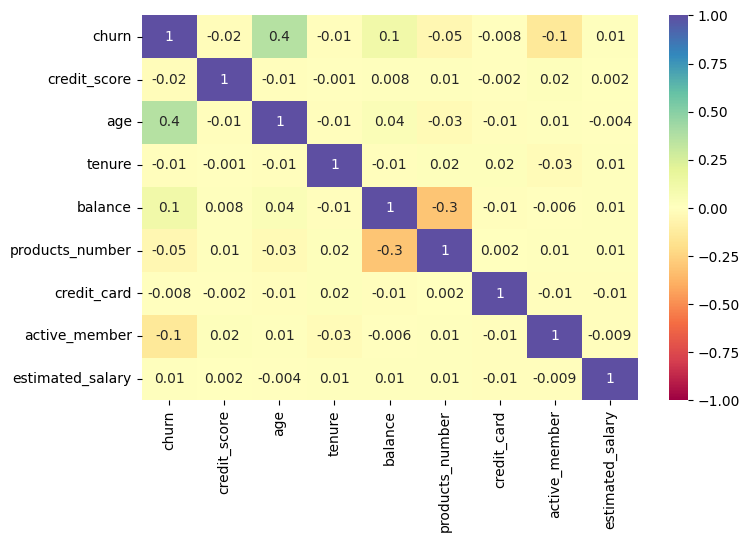

In [ ]:
plt.rcParams['figure.figsize']=[8, 5]
sns.heatmap(df_new.corr(),  annot = True ,fmt = '.1g', vmin = -1, vmax = 1, center = 0, cmap = 'Spectral');

#Performing AutoML with new dataframe

In [ ]:
hf_new = h2o.H2OFrame(df_new)
hf_new.shape

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


(9574, 9)

In [ ]:
hf_new['churn'] = hf_new['churn'].asfactor()

In [ ]:
#Seperate Dependent variable from Independent variable
X_new=hf_new.columns
y_new_numeric ='churn'
X_new.remove(y_new_numeric)
print(X_new)

['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']


In [ ]:
# Create a 80/20 train/test split
pct_rows=0.80
hf_new_train, hf_new_test = hf_new.split_frame([pct_rows])

In [ ]:
auml_new = H2OAutoML(max_runtime_secs=run_time, seed=1)
auml_new.train(x=X_new,y=y_new_numeric,training_frame=hf_new_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_2_20240219_62112


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       4/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# DeepLearning base models (used / total)  1/1
# DRF base models (used / total)           1/2
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09901505246503399
RMSE: 0.3146665734790303
LogLoss: 0.32490958765172534
AUC: 0.8732739763537695
AUCPR: 0.716280255329786
Gini: 0.7465479527075389
Null degrees of freedom: 7672
Residual degrees of freedom: 7668
Null deviance: 7702.407941040453
Residual deviance: 4986.062532103375
AIC: 4996.062532103375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3741389915016979
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      5742  388   0.0633   (388.0/6130.0)
1      653   890   0.4232   (653.0/1543.0)
Total  6395  1278  0.1357   (1041.0/7673.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374139     0.630982  176
max f2                       0.123653     0.706085  297
max f0point5                 0.45247      0.696087  146
max accuracy                 0.45247      0.869543  146
max precision                0.988682     1         0
max recall                   0.0189506    1         395
max specificity              0.988682     1         0
max absolute_mcc             0.394493     0.556784  168
max min_per_class_accuracy   0.174701     0.781077  263
max mean_per_class_accuracy  0.196208     0.787132  250
max tns                      0.988682     6130      0
max fns                      0.988682     1539      0
max fps                      0.0147558    6130      399
max tps                      0.0189506    1543      395
max tnr                      0.988682     1         0
max fnr                      0.988682     0.997408  0
max fpr                      0.0147558    1         399
max tpr                      0.0189506    1         395

Gains/Lift Table: Avg response rate: 20.11 %, avg score: 19.92 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100352                   0.951329           4.97278    4.97278            1                0.966714   1                           0.966714            0.0499028       0.0499028                  397.278   397.278            0.0499028
2        0.0200704                   0.925551           4.9082     4.94049            0.987013         0.937814   0.993506                    0.952264            0.0492547       0.0991575                  390.82    394.049            0.0989944
3        0.0301056                   0.898554           4.97278    4.95125            1                0.912888   0.995671                    0.939139            0.0499028       0.14906                    397.278   395.125            0.148897
4        0.0

In [ ]:
print(auml_new.leaderboard)

model_id                                                     auc    logloss     aucpr    mean_per_class_error      rmse       mse
StackedEnsemble_BestOfFamily_4_AutoML_2_20240219_62112  0.846364   0.351042  0.665242                0.250125  0.327914  0.107528
StackedEnsemble_AllModels_3_AutoML_2_20240219_62112     0.84574    0.351315  0.665045                0.257119  0.328015  0.107594
GBM_grid_1_AutoML_2_20240219_62112_model_2              0.84573    0.352578  0.663594                0.251469  0.328027  0.107602
StackedEnsemble_AllModels_2_AutoML_2_20240219_62112     0.843693   0.353397  0.661195                0.257445  0.329129  0.108326
StackedEnsemble_BestOfFamily_3_AutoML_2_20240219_62112  0.842945   0.354024  0.660555                0.257307  0.329415  0.108514
GBM_grid_1_AutoML_2_20240219_62112_model_7              0.842898   0.35661   0.659671                0.244101  0.329929  0.108853
GBM_grid_1_AutoML_2_20240219_62112_model_3              0.841076   0.357082  0.654348     

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                     auc    logloss     aucpr    mean_per_class_error      rmse       mse    training_time_ms    predict_time_per_row_ms  algo
------------------------------------------------------  --------  ---------  --------  ----------------------  --------  --------  ------------------  -------------------------  ---------------
GBM_grid_1_AutoML_2_20240219_62112_model_2              0.844367   0.35036   0.680441                0.255884  0.32633   0.106492                 396                   0.012566  GBM
StackedEnsemble_AllModels_3_AutoML_2_20240219_62112     0.844227   0.350112  0.678773                0.2397    0.326778  0.106784                1667                   0.073603  StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_2_20240219_62112  0.843076   0.350132  0.677911                0.264769  0.326686  0.106724                 693                   0.037095  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_2_20240219_62112     0.842347   0.353088  0.675268                0.243659  0.327938  0.107543                1092                   0.067382  StackedEnsemble
GBM_grid_1_AutoML_2_20240219_62112_model_3              0.84172    0.353788  0.674447                0.252936  0.328214  0.107725                 453                   0.018936  GBM
StackedEnsemble_AllModels_2_AutoML_2_20240219_62112     0.841501   0.352816  0.672009                0.248091  0.328309  0.107787                 923                   0.043427  StackedEnsemble
GBM_grid_1_AutoML_2_20240219_62112_model_7              0.841354   0.355046  0.673012                0.258749  0.328511  0.10792                  517                   0.018427  GBM
GBM_2_AutoML_2_20240219_62112                           0.841354   0.355763  0.668782                0.246978  0.329863  0.10881                  816                   0.012505  GBM
GBM_5_AutoML_2_20240219_62112                           0.84104    0.354224  0.668985                0.250235  0.328971  0.108222                 573                   0.012743  GBM
StackedEnsemble_BestOfFamily_3_AutoML_2_20240219_62112  0.840482   0.353889  0.670525                0.252276  0.328801  0.10811                  638                   0.03753   StackedEnsemble
GBM_grid_1_AutoML_2_20240219_62112_model_6              0.839908   0.356519  0.668835                0.255615  0.329324  0.108455                 978                   0.027274  GBM
StackedEnsemble_BestOfFamily_2_AutoML_2_20240219_62112  0.839615   0.355335  0.670752                0.252585  0.328743  0.108072                 792                   0.03846   StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_2_20240219_62112  0.839563   0.355467  0.670544                0.252585  0.328772  0.108091                 540                   0.031338  StackedEnsemble
GBM_1_AutoML_2_20240219_62112                           0.838741   0.356304  0.669763                0.244978  0.329102  0.108308                 748                   0.015349  GBM
GBM_3_AutoML_2_20240219_62112                           0.837974   0.357185  0.668396                0.248008  0.329751  0.108736                 976                   0.013854  GBM
XGBoost_grid_1_AutoML_2_20240219_62112_model_11         0.837208   0.361286  0.667622                0.257862  0.329922  0.108849                 193                   0.005246  XGBoost
XGBoost_3_AutoML_2_20240219_62112                       0.837034   0.359551  0.654974                0.260666  0.332575  0.110606                 524                   0.006877  XGBoost
XGBoost_grid_1_AutoML_2_20240219_62112_model_9          0.834685   0.359538  0.661312                0.2524    0.330946  0.109525                 938                   0.00546   XGBoost
XGBoost_grid_1_AutoML_2_20240219_62112_model_2          0.833059   0.364889  0.657099                0.24974   0.333813  0.111431                 726                   0.009564  XGBoost
XGBoost_grid_1_AutoML_2_20240219_62112_model_7          0.831947 

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_4_AutoML_2_20240219_62112

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37724277459899686
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      1422  94   0.062    (94.0/1516.0)
1      180   205  0.4675   (180.0/385.0)
Total  1602  299  0.1441   (274.0/1901.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

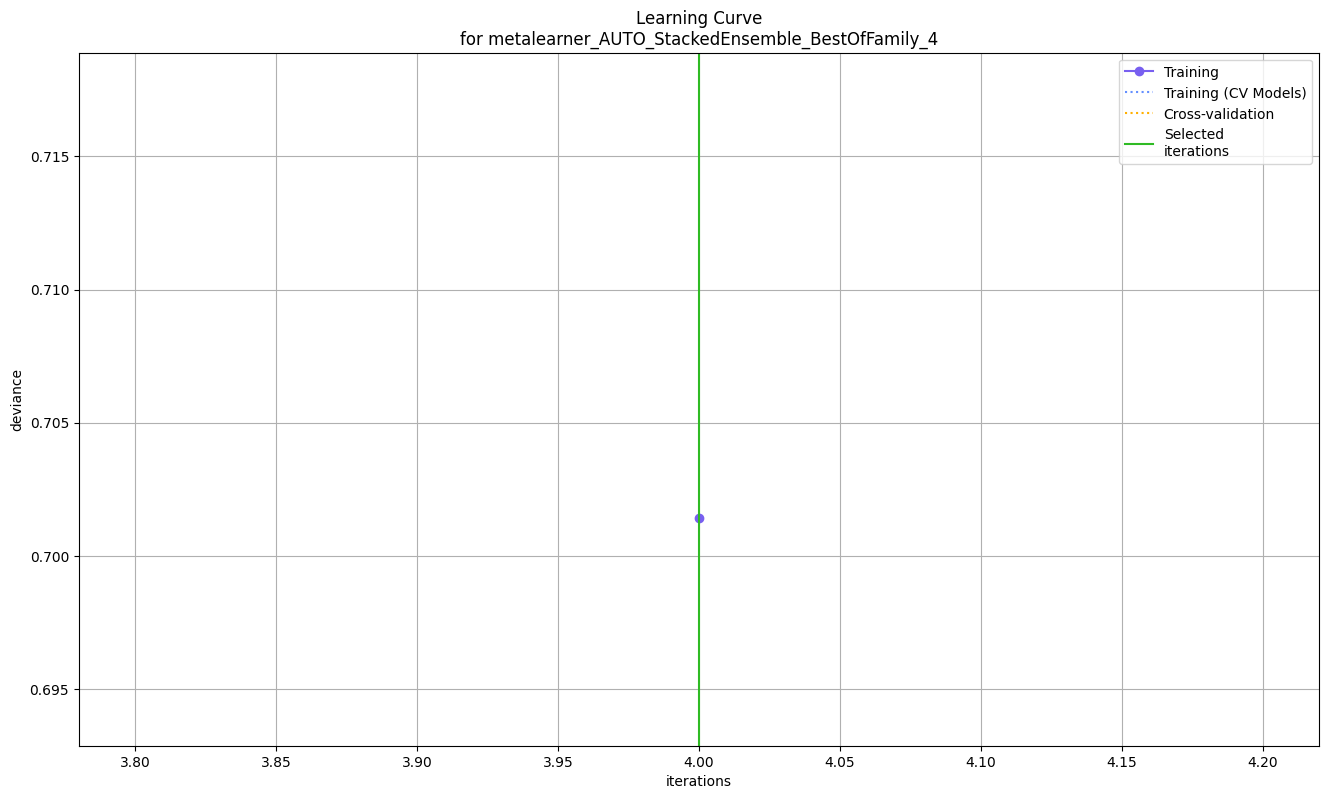

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

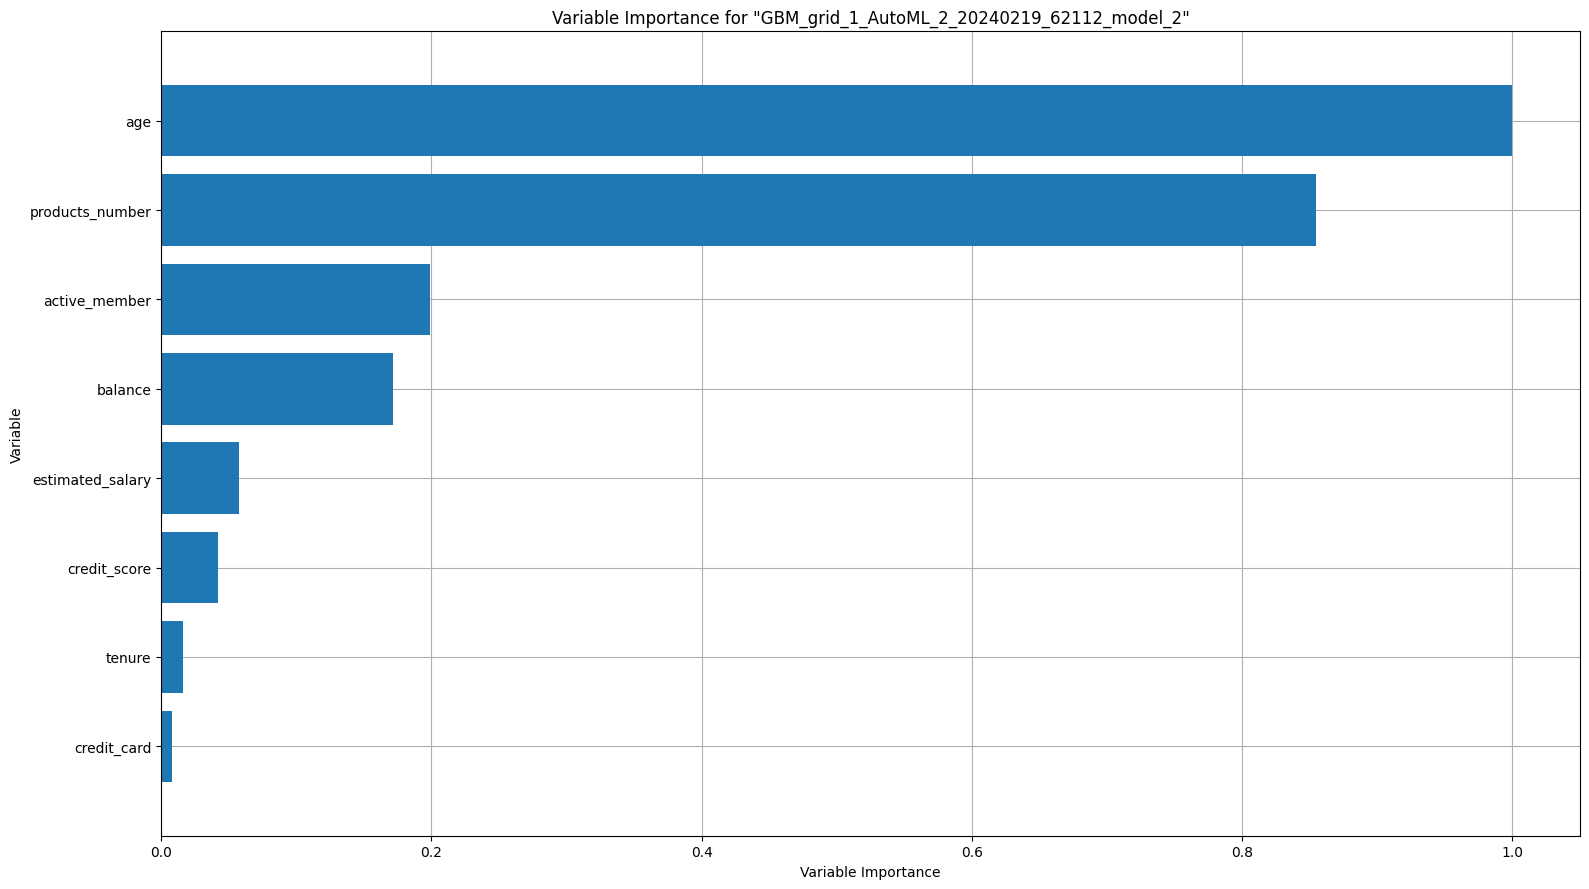

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

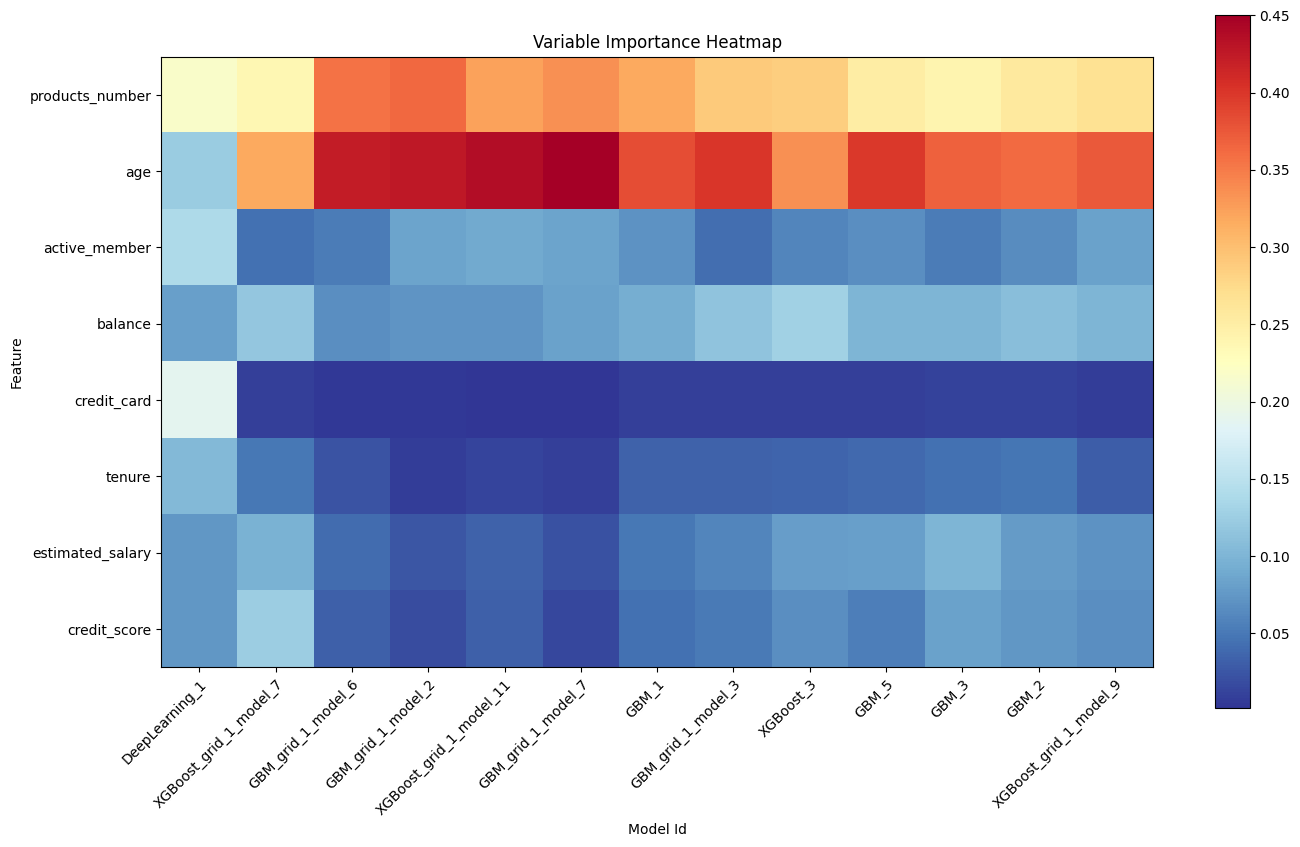

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

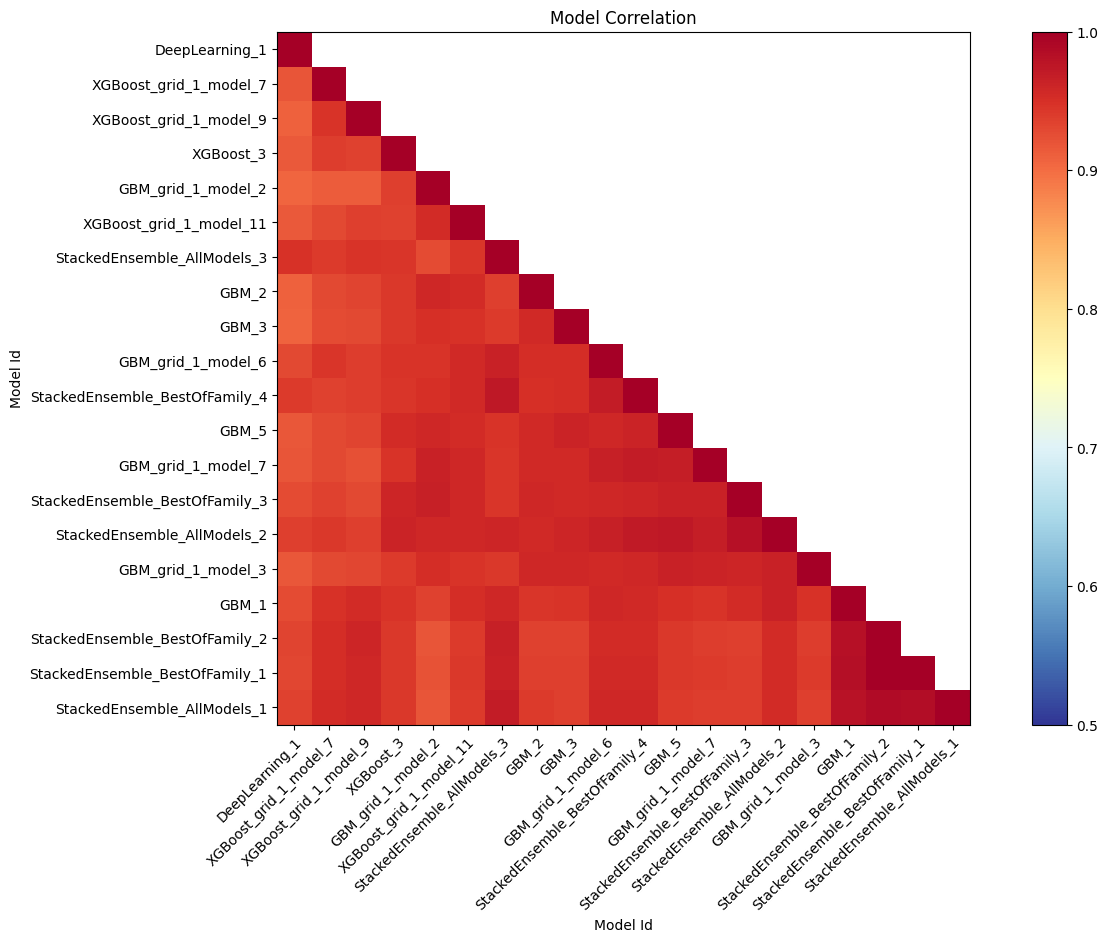

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

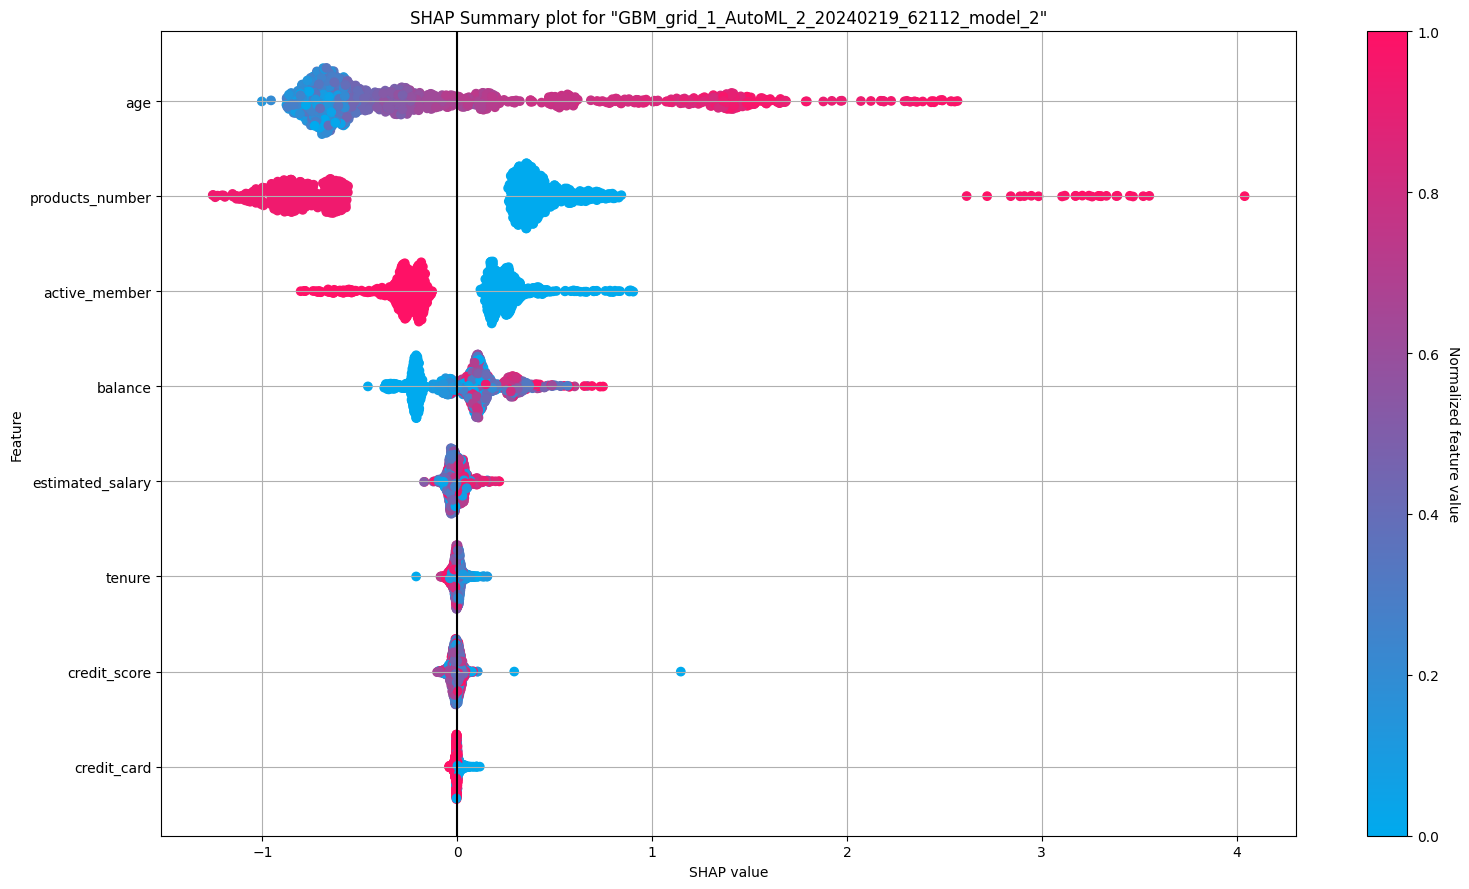

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

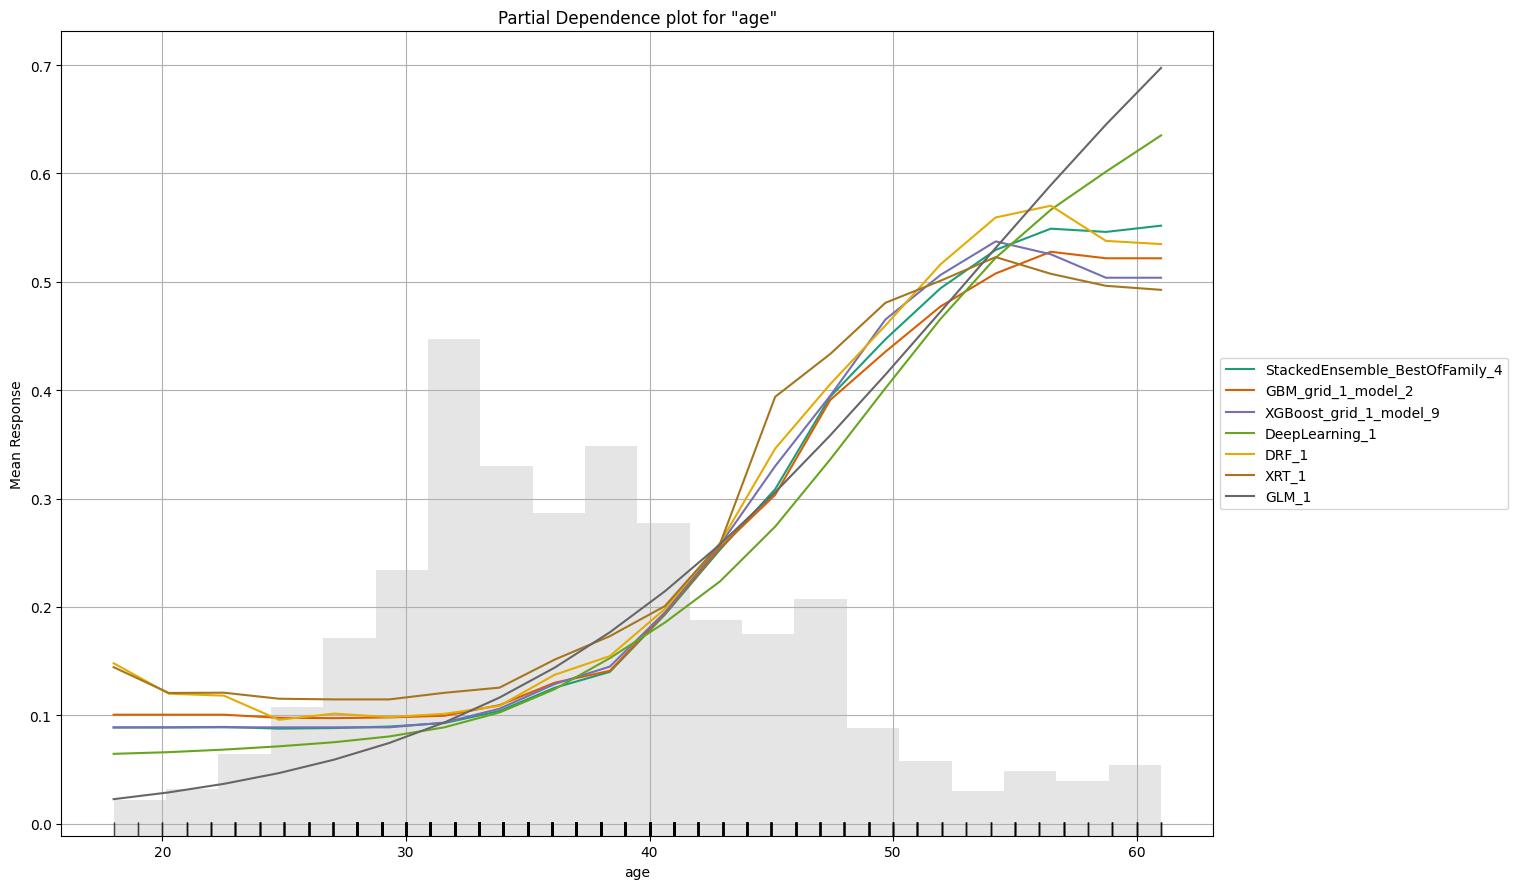

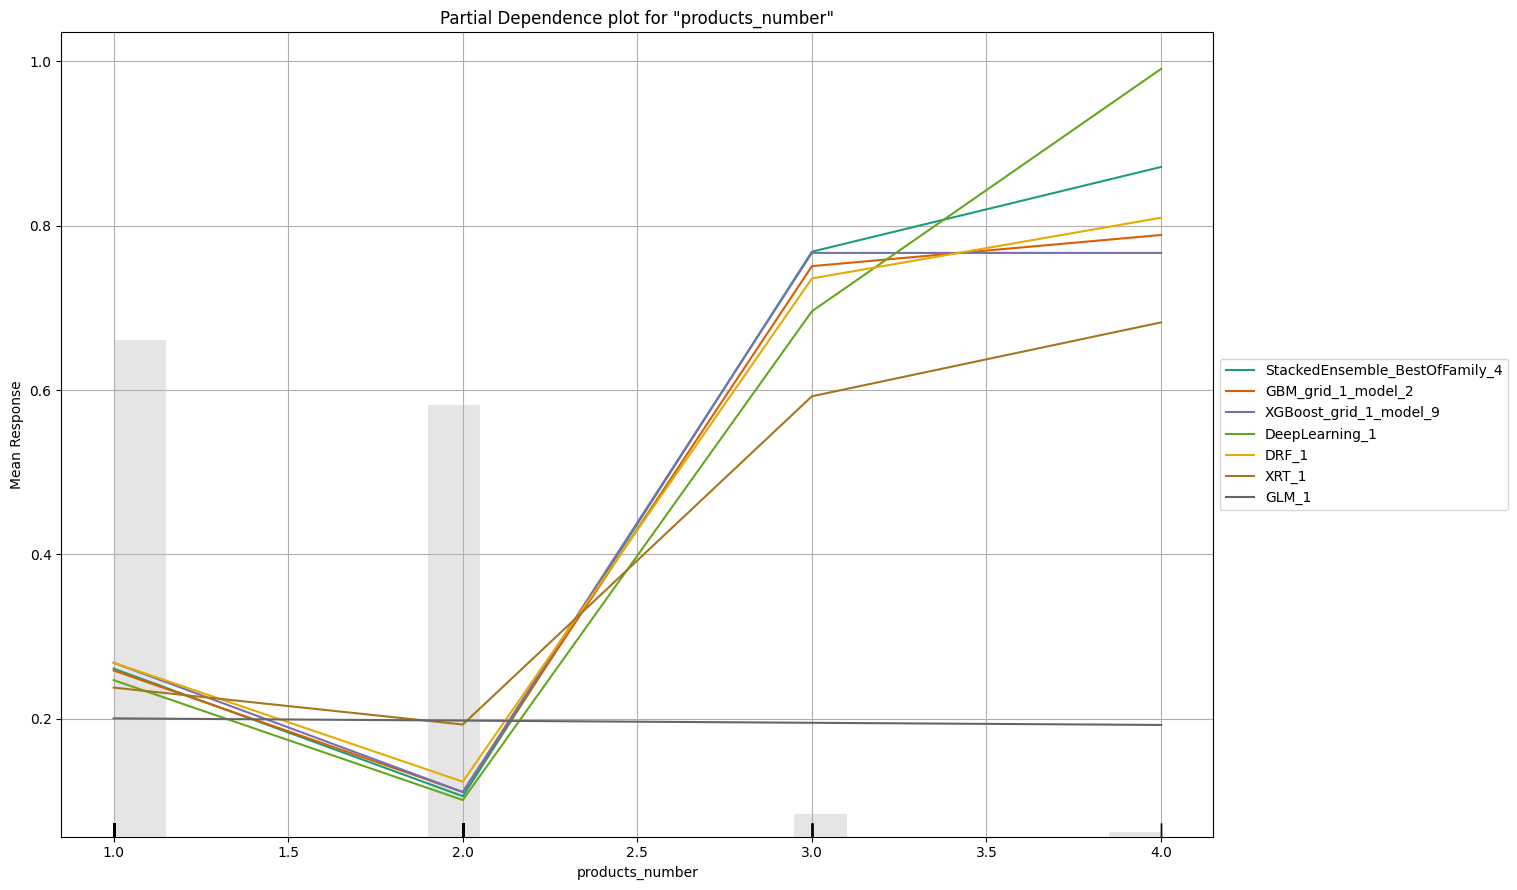

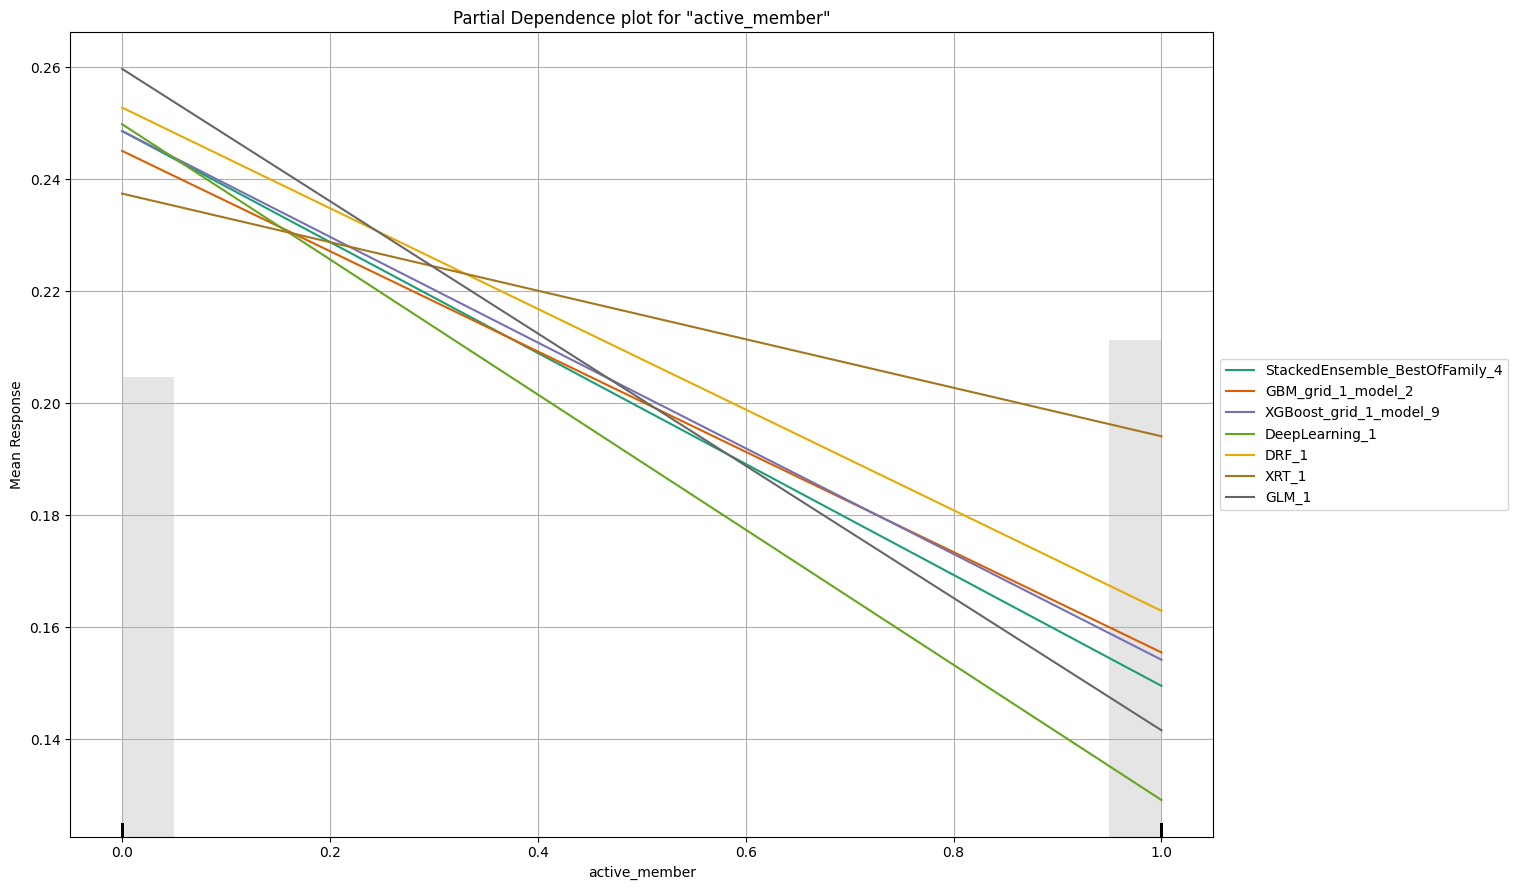

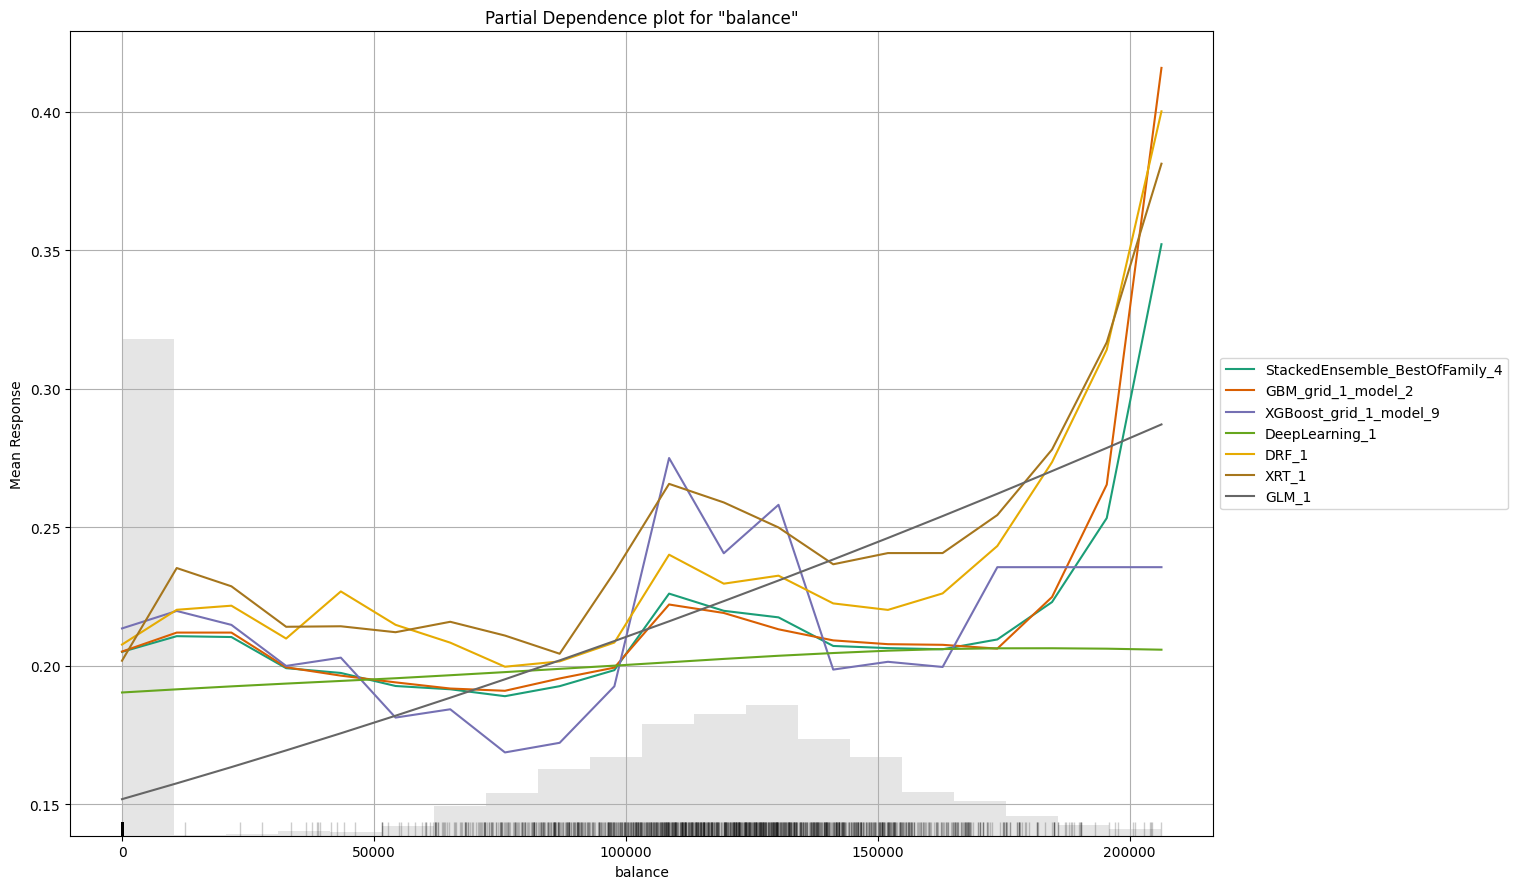

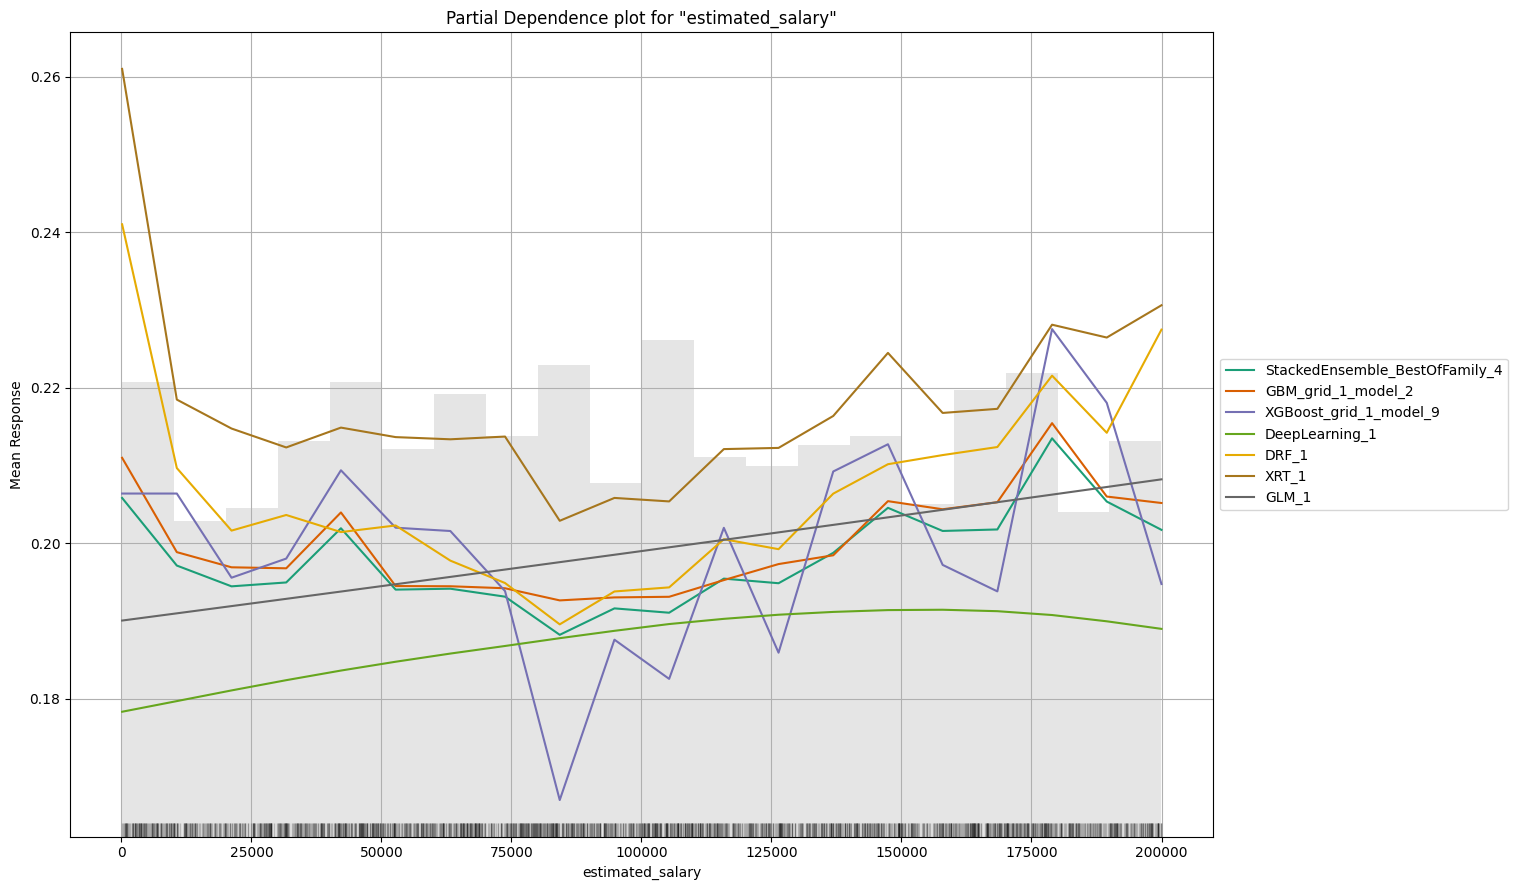

In [ ]:
exa_new = auml_new.explain(hf_new_test)

# Q6. Does the model make sense?

Ans: Yes, The model's findings are meaningful, as it is reasonable to expect that certain age groups are more likely are to churn. <br>

Additionally, the model highlights that Product number, balance and active member is likely to have a significant impact on the churn.

# Q7. Does regularization help?

Using Ridge Regularization

In [ ]:
hf_new = h2o.H2OFrame(df_new)
hf_new.shape

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


(9574, 9)

In [ ]:
hf_new['churn'] = hf_new['churn'].asfactor()

In [ ]:
#Seperate Dependent variable from Independent variable
X_new=hf_new.columns
y_new_numeric ='churn'
X_new.remove(y_new_numeric)
print(X_new)

['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']


In [ ]:
# Create a 80/20 train/test split
pct_rows=0.80
hf_new_train, hf_new_test = hf_new.split_frame([pct_rows])

In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
house_glm = H2OGeneralizedLinearEstimator(family = 'binomial', lambda_ = 0, compute_p_values = True)
house_glm_regularization = H2OGeneralizedLinearEstimator(family = 'binomial', lambda_ = .001, alpha = 0)

In [ ]:
house_glm_regularization.train(x = X_new, y = y_new_numeric, training_frame = hf_new_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708323296429_6362


GLM Model: summary
    family    link    regularization            number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Ridge ( lambda = 0.001 )  8                             8                              4                       py_1941_sid_b895

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.13194781187465895
RMSE: 0.36324621384765865
LogLoss: 0.4217889819472045
AUC: 0.771407466383581
AUCPR: 0.5160087685881805
Gini: 0.5428149327671621
Null degrees of freedom: 7689
Residual degrees of freedom: 7681
Null deviance: 7784.084144253013
Residual deviance: 6487.114542348006
AIC: 6505.114542348006

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2601651047701878
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      4945  1175  0.192    (1175.0/6120.0)
1      628   942   0.4      (628.0/1570.0)
Total  5573  2117  0.2345   (1803.0/7690.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.260165     0.510985  201
max f2                       0.14793      0.617138  281
max f0point5                 0.451149     0.522774  114
max accuracy                 0.451149     0.821196  114
max precision                0.868023     1         0
max recall                   0.00892472   1         399
max specificity              0.868023     1         0
max absolute_mcc             0.342345     0.377542  159
max min_per_class_accuracy   0.20011      0.70828   241
max mean_per_class_accuracy  0.207725     0.712255  236
max tns                      0.868023     6120      0
max fns                      0.868023     1569      0
max fps                      0.00892472   6120      399
max tps                      0.00892472   1570      399
max tnr                      0.868023     1         0
max fnr                      0.868023     0.999363  0
max fpr                      0.00892472   1         399
max tpr                      0.00892472   1         399

Gains/Lift Table: Avg response rate: 20.42 %, avg score: 20.42 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010013                    0.730785           4.58003   4.58003            0.935065         0.783417   0.935065                    0.783417            0.0458599       0.0458599                  358.003   358.003            0.0450429
2        0.020026                    0.679932           3.56225   4.07114            0.727273         0.703423   0.831169                    0.74342             0.0356688       0.0815287                  256.225   307.114            0.0772803
3        0.030039                    0.637322           2.98974   3.71067            0.61039          0.656494   0.757576                    0.714444            0.0299363       0.111465                   198.974   271.067            0.102315
4        0.040052                    0.602835           2.7353    3.46683            0.558442         0.619927   0.707792                    0.690815            0.0273885       0.138854                   173.53    246.683            0.124148
5        0.050065          

Impact of regularization

**MSE (Mean Squared Error):**

Before regularization: 0.09896

After regularization: 0.12881

Increase in MSE indicates that the model's predictive accuracy has decreased after regularization.

**RMSE (Root Mean Squared Error):**

Before regularization: 0.31457

After regularization: 0.35890

Similar to MSE, an increase in RMSE suggests a decrease in the model's accuracy.

# Q9. Which hyperparameters are important?

We have only used runtime and memeory as hyperparameter in our process thus those are important parameters to us

# References and License

Analytics Vidya

https://stackoverflow.com/questions/66324765/get-accuracy-metric-from-leaderboard-function-when-using-h20-ai/66325195#66325195

medium: towardsdatascience

Seaborn: statistical data visualization

geeksforgeeks

https://docs.h2o.ai/

Assignment_1_ML_Data_Cleaning_and_Feature_Selection.ipynb

MIT License

Copyright (c) 2024 anshvaghela2099

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.